Heart diseases prediction

EDA and data preprocessing

In [114]:
# Import libraries
import sqlite3
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc, RocCurveDisplay, make_scorer
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
from scipy.stats import skew, kurtosis, norm, ttest_ind, chi2_contingency

# Modelling libraries
import optuna
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle

# General settings 
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

Data aquisition from database

In [115]:
db_name = r'.\Data\db_heart_disease.db'
conn = sqlite3.connect(db_name)

query = 'SELECT * FROM tbl_observations;'
df = pd.read_sql_query(query, conn)

conn.close()

Checking what's in the dataset

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4240 non-null   object 
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4240 non-null   object 
 5   BPMeds           4240 non-null   object 
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4240 non-null   object 
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4240 non-null   object 
 13  heartRate        4240 non-null   object 
 14  glucose          4240 non-null   object 
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(2), int64(7), object(7)
memory usage: 530.1+ KB


In [117]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
1,0,46,2,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
2,1,48,1,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
3,0,61,3,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
4,0,46,3,1,23,0,0,0,0,285,130.0,84.0,23.1,85,85,0


In [118]:
df.tail()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
4235,0,48,2,1,20,NA,0,0,0,248,131.0,72.0,22,84,86,0
4236,0,44,1,1,15,0,0,0,0,210,126.5,87.0,19.16,86,NA,0
4237,0,52,2,0,0,0,0,0,0,269,133.5,83.0,21.47,80,107,0
4238,1,40,3,0,0,0,0,1,0,185,141.0,98.0,25.6,67,72,0
4239,0,39,3,1,30,0,0,0,0,196,133.0,86.0,20.91,85,80,0


**Data preprocessing**

Reneming 'male' column

In [119]:
df.rename(columns={'male': 'sex'}, inplace=True)

Data types conversion and missing values analysis:
- Some data types are incorrect (object) and they will be recoded into int/float type.
- All rows with missing data will be remove.

In [120]:
for column in df.columns:
    print(f'Unique values in column: {column}:')
    print(df[column].unique())
    print('-' * 40)

Unique values in column: sex:
[1 0]
----------------------------------------
Unique values in column: age:
[39 46 48 61 43 63 45 52 50 41 38 42 44 47 60 35 36 59 54 37 56 53 49 65
 51 62 40 67 57 66 64 55 58 34 68 33 70 32 69]
----------------------------------------
Unique values in column: education:
['4' '2' '1' '3' 'NA']
----------------------------------------
Unique values in column: currentSmoker:
[0 1]
----------------------------------------
Unique values in column: cigsPerDay:
[0 20 30 23 15 9 10 5 35 43 1 40 3 2 'NA' 12 4 18 25 60 14 45 8 50 13 11 7
 6 38 29 17 16 19 70]
----------------------------------------
Unique values in column: BPMeds:
['0' '1' 'NA']
----------------------------------------
Unique values in column: prevalentStroke:
[0 1]
----------------------------------------
Unique values in column: prevalentHyp:
[0 1]
----------------------------------------
Unique values in column: diabetes:
[0 1]
----------------------------------------
Unique values in column:

In [121]:
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].replace('NA', np.nan)
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column] = df[column].astype('float64')

In [122]:
# Calculate missing values for each column
missing_values = df.isna().sum()
print('Missing values in each attribute:')
print(missing_values)

# Calculate the total percentage of missing values in the dataset
total_percentage_mv = (missing_values.sum() / df.shape[0]) * 100
print('\nTotal % of missing values in the dataset:')
print(f'{round(total_percentage_mv, 2)} %')


Missing values in each attribute:
sex                  0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Total % of missing values in the dataset:
15.21 %


Missing values imputation

In [123]:
df = df.dropna()

In [124]:
df.shape

(3658, 16)

In [125]:
df['education'] = df['education'].astype(int)

Checking duplicates

In [126]:
df.duplicated().sum()

0

**Exploratory Data Analysis**

In [127]:
df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.443685,49.551941,1.980317,0.489065,9.025424,0.030344,0.005741,0.311646,0.027064,236.847731,132.370558,82.917031,25.782802,75.730727,81.852925,0.152269
std,0.496886,8.562029,1.022656,0.499949,11.921590,0.171557,0.075561,0.463229,0.162292,44.097681,22.086866,11.974258,4.065601,11.981525,23.904164,0.359331
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.875000,90.000000,28.037500,82.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Target variable analysis:
- The dataset contains 3658 cases, of which 3101 do not belong to the group at risk of coronary heart disease, while 557 do.
- Therefore, the dataset exhibits an imbalance in the target variable categories

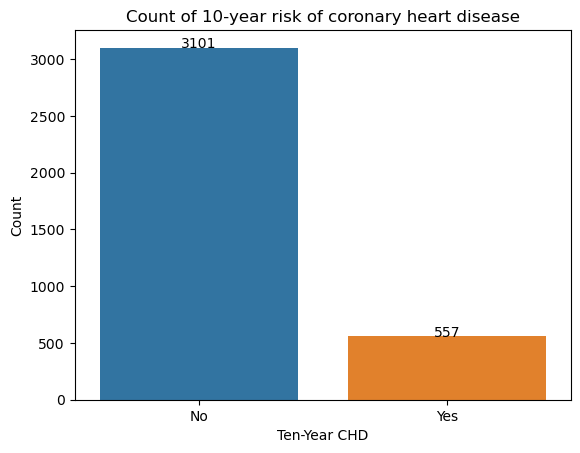

In [128]:
df['TenYearCHD_plot'] = df['TenYearCHD'].map({0: 'No', 1: 'Yes'})

ax = sns.countplot(x='TenYearCHD_plot', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10)

plt.title('Count of 10-year risk of coronary heart disease')
plt.xlabel('Ten-Year CHD')
plt.ylabel('Count')

plt.show()

Categorical features analysis

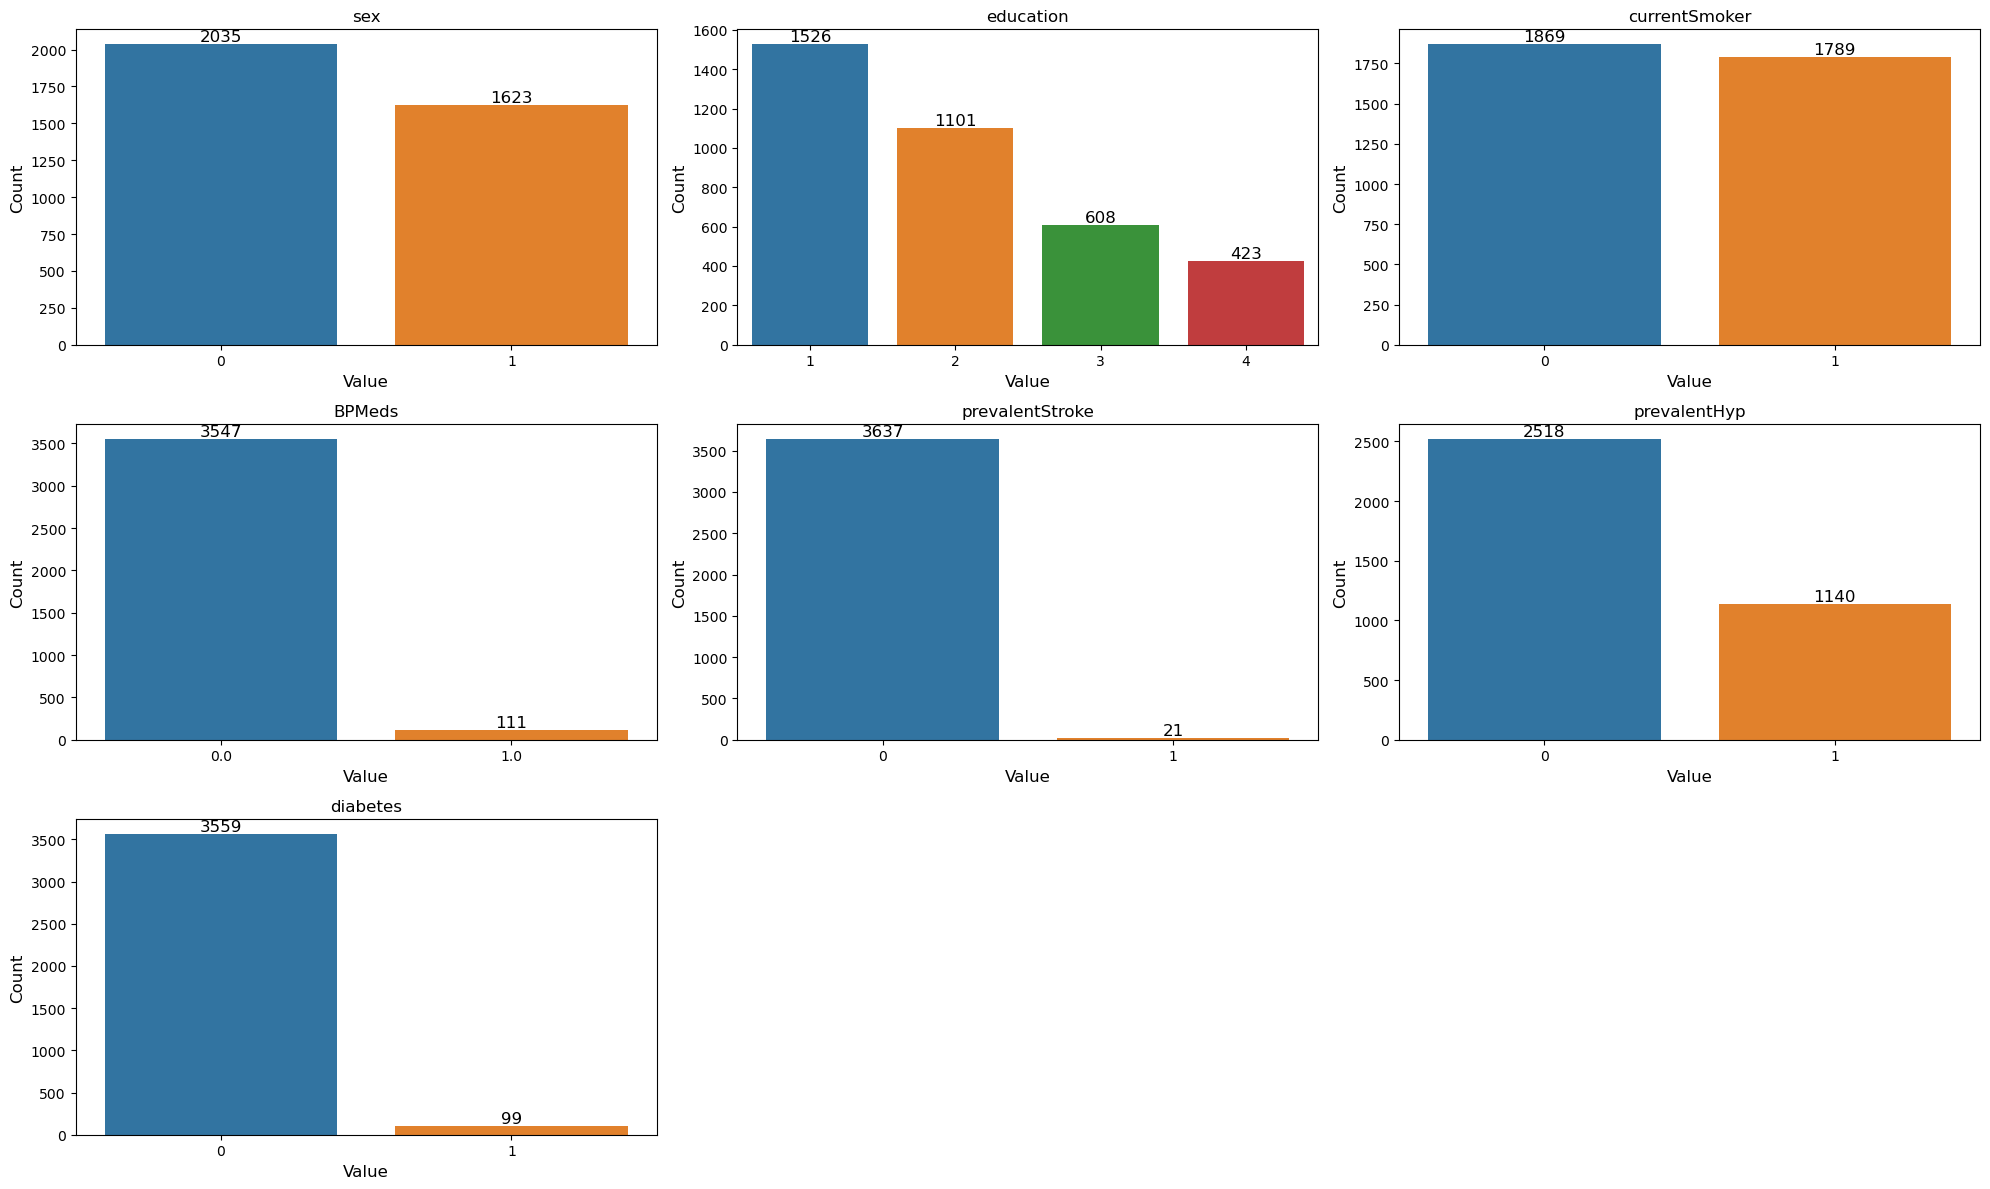

In [129]:
# Count bar chart grid for each variable to examine outliers, error data values and feature distribution

# Categorical columns list
cat_columns = [col for col in df.columns if col in ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']]

# Chart grid settings
n_cols = 3  
n_rows = int(np.ceil(len(cat_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Generating plots
for i, col in enumerate(cat_columns):
    # Liczebność dla każdej wartości (0/1)
    count_data = df[col].value_counts()
    sns.barplot(
        x=count_data.index,
        y=count_data.values,
        ax=axes[i],  
    )
    # Labels
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("Value", fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", 
                         (p.get_x() + p.get_width() / 2, p.get_height()), 
                         ha="center", va="bottom", fontsize=12)

# Hide empty axes (if variables are less than n_rows * n_cols)
for j in range(len(cat_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


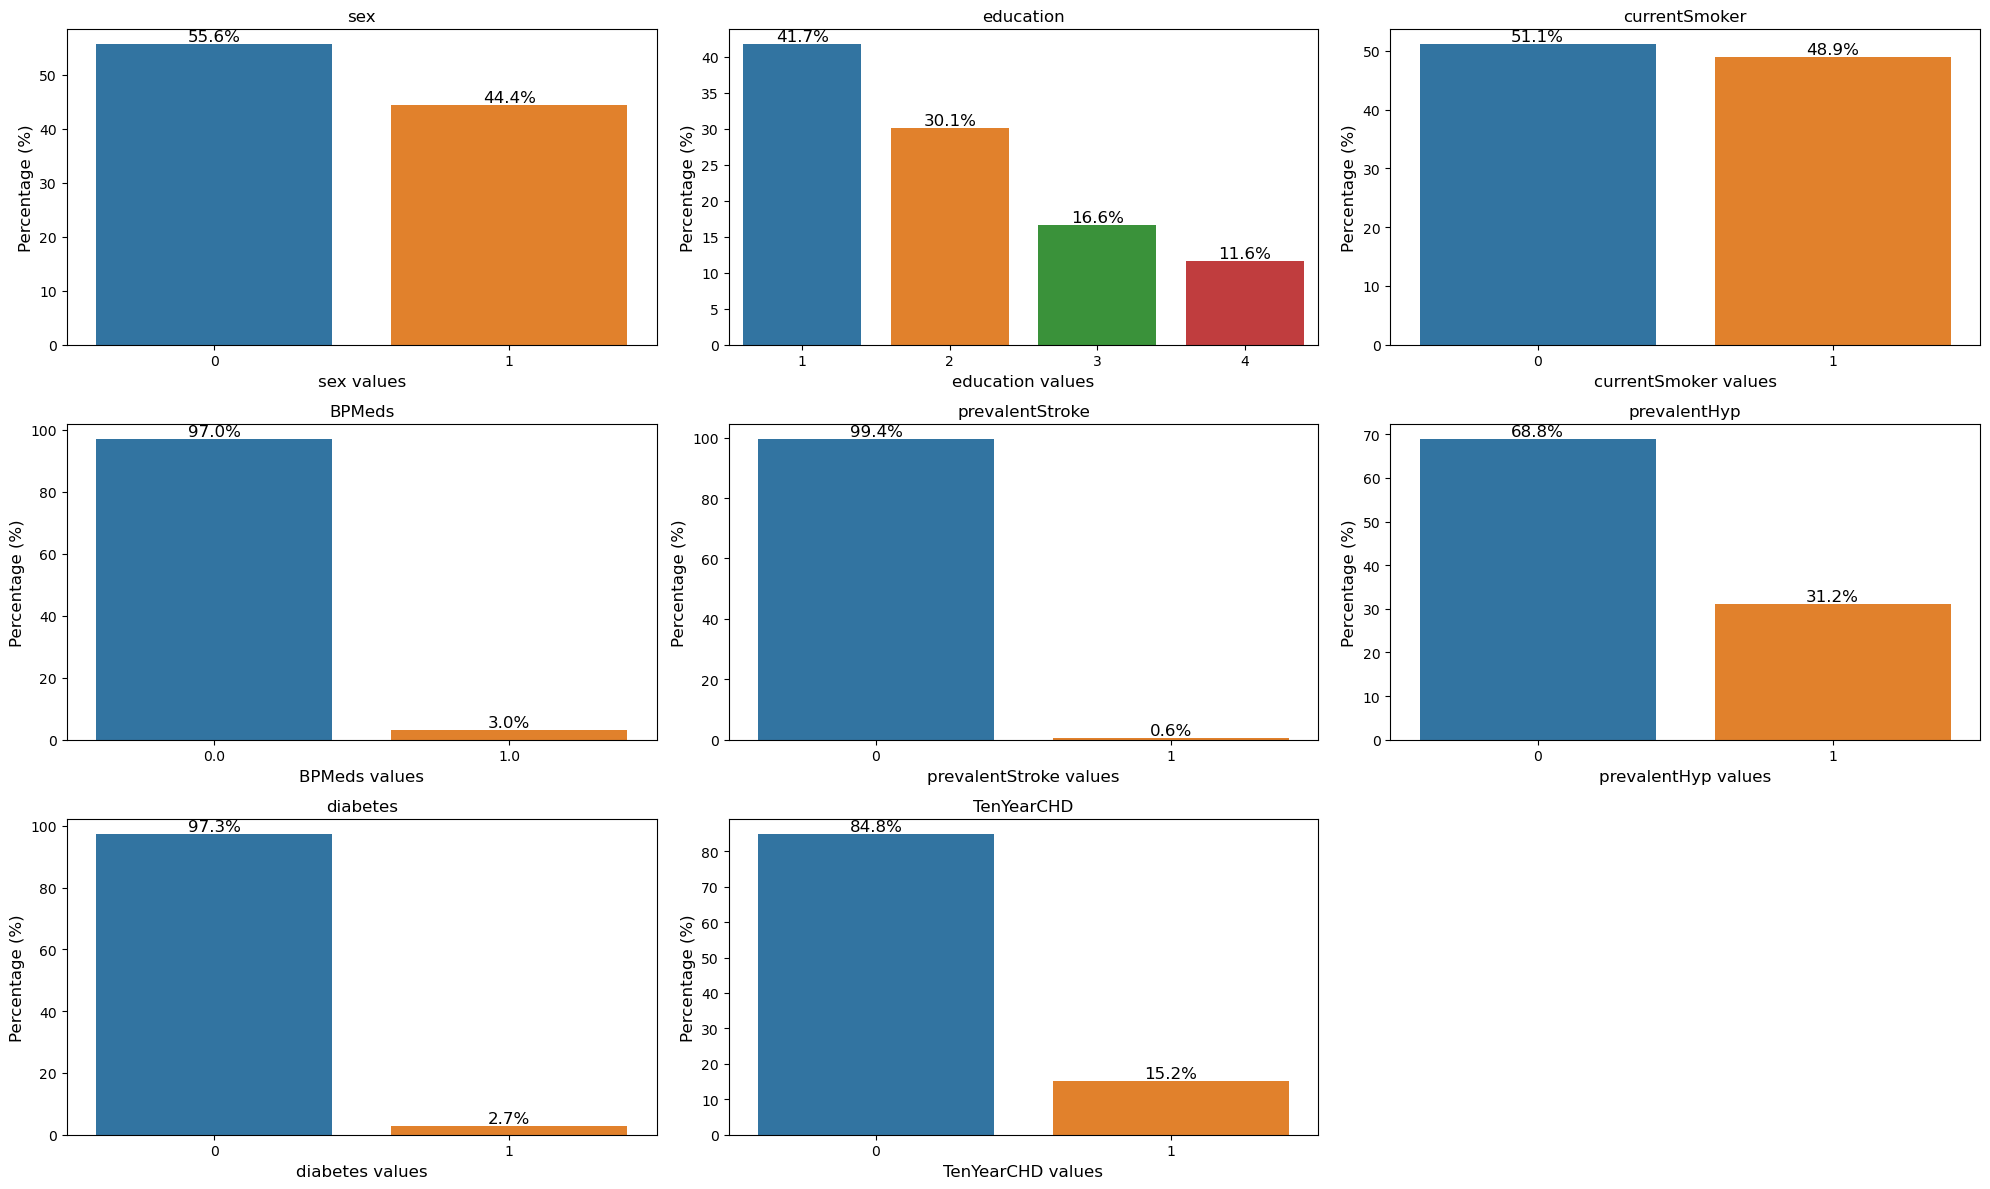

In [130]:
# % bar chart grid for each variable to examine outliers, error data values and feature distribution

# Intiger columns list 
cat_columns = [col for col in df.columns if col in ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']]


# Chart grid settings
n_cols = 3  
n_rows = int(np.ceil(len(cat_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Generating plots
for i, col in enumerate(cat_columns):
    # % for each value (0/1)
    percent_data = df[col].value_counts(normalize=True) * 100
    sns.barplot(
        x=percent_data.index,
        y=percent_data.values,
        ax=axes[i],
    )
    # Labels
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel(f"{col} values", fontsize=12)
    axes[i].set_ylabel("Percentage (%)", fontsize=12)
    for p in axes[i].patches:
        axes[i].annotate(f"{p.get_height():.1f}%", 
                         (p.get_x() + p.get_width() / 2, p.get_height()), 
                         ha="center", va="bottom", fontsize=12)

# Hide empty axes (if variables are less than n_rows * n_cols)
for j in range(len(cat_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In four categorical variables, there are significant discrepancies in the distribution of values. For example, only 21 people (0.6%) have had a stroke in the past, 111 people (3%) take blood pressure medication, and 99 people (2.7%) have been diagnosed with diabetes. This indicates that these variables may have low predictive value. On the other hand, if, for example, stroke is a strong predictor of heart disease, even a small number of cases can provide valuable information. It all depends on the specificity of the data and the purpose of the analysis.

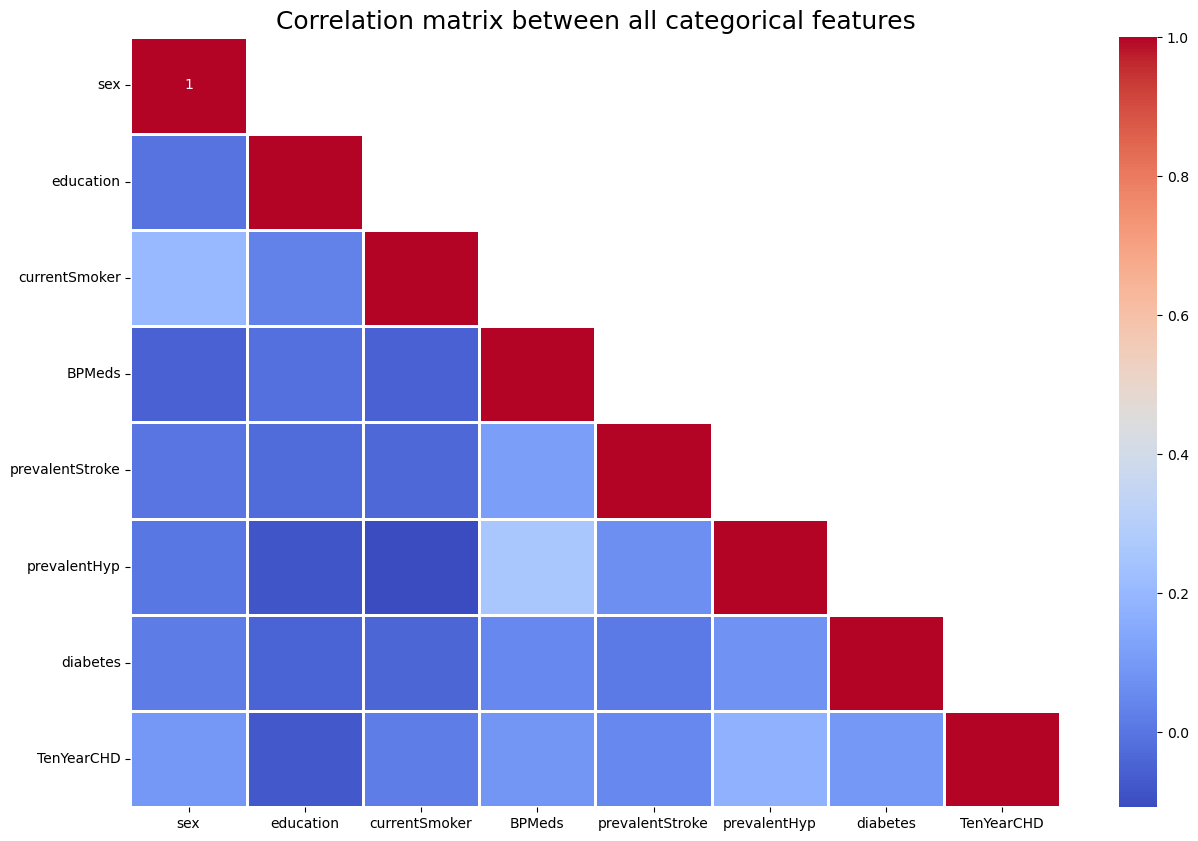

In [131]:
# correlation matrix for categorical features
cat_corr_matrix = df[cat_columns].corr(method='spearman')

# lower and upper triangle masks 
cat_upper_mask = np.triu(cat_corr_matrix, k=1)
cat_lower_mask = np.tril(cat_corr_matrix, k=1)

# correlation between categorical features
plt.figure(figsize=(15,10))
sns.heatmap(df[cat_columns].corr(method='spearman'), mask=cat_upper_mask, cmap='coolwarm', linewidths=2, annot=True)
plt.title('Correlation matrix between all categorical features', fontsize=18)
plt.show()

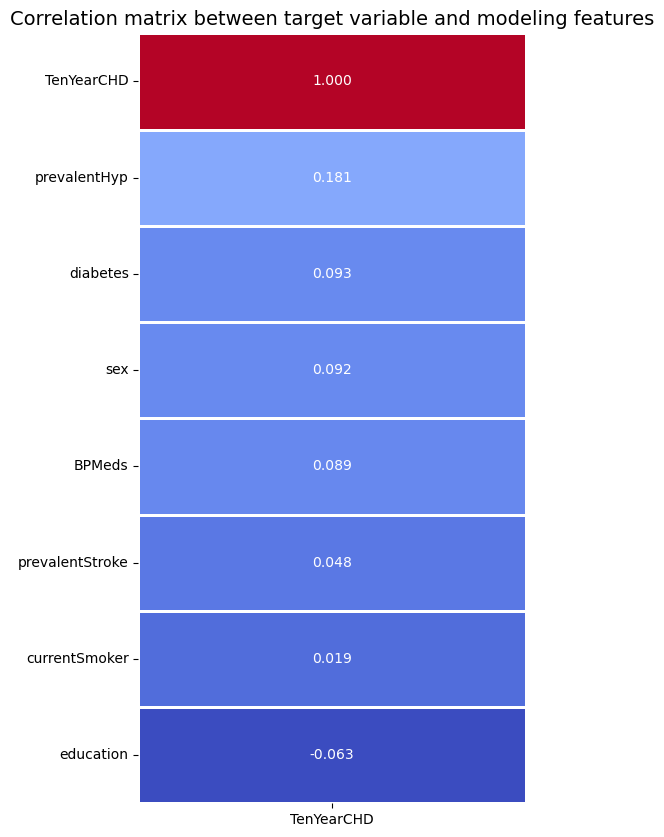

In [132]:
target_column_df = df['TenYearCHD']

cat_correlation_df = df[cat_columns]

correlation_matrix = cat_correlation_df.corr()

TenYearCHD_correlation = correlation_matrix['TenYearCHD'].sort_values(ascending=False)

plt.figure(figsize=(5, 10))
sns.heatmap(TenYearCHD_correlation.to_frame(), annot=True, cmap='coolwarm', linewidths=2, cbar=False, fmt='.3f')
plt.title('Correlation matrix between target variable and modeling features', fontsize=14)
plt.show()

In [133]:
for column in cat_columns:
    # Create the crosstab with numeric values
    crosstab = pd.crosstab(df['TenYearCHD'], df[column], margins=True, margins_name='Total')
    
    # Create the crosstab with percentage values
    crosstab_percentage = crosstab.div(crosstab.loc['Total'], axis=1) * 100
    crosstab_percentage = crosstab_percentage.applymap(lambda x: f'{x:.2f}%')
    
    # Print the title and numeric crosstab
    print(f'Crosstab for {column}')
    print(crosstab)
    
    # Print the title and percentage crosstab
    print(f'\nPercentage Crosstab for {column}')
    print(crosstab_percentage)
    
    # For better readability
    print('\n' + '='*50 + '\n')


Crosstab for sex
sex            0     1  Total
TenYearCHD                   
0           1785  1316   3101
1            250   307    557
Total       2035  1623   3658

Percentage Crosstab for sex
sex               0        1    Total
TenYearCHD                           
0            87.71%   81.08%   84.77%
1            12.29%   18.92%   15.23%
Total       100.00%  100.00%  100.00%


Crosstab for education
education      1     2    3    4  Total
TenYearCHD                             
0           1235   970  533  363   3101
1            291   131   75   60    557
Total       1526  1101  608  423   3658

Percentage Crosstab for education
education         1        2        3        4    Total
TenYearCHD                                             
0            80.93%   88.10%   87.66%   85.82%   84.77%
1            19.07%   11.90%   12.34%   14.18%   15.23%
Total       100.00%  100.00%  100.00%  100.00%  100.00%


Crosstab for currentSmoker
currentSmoker     0     1  Total
TenYearCHD  

**Interpretation of Crosstab Results**

Sex

- Distribution: Among individuals with no coronary heart disease (CHD), 87.71% are female (sex=0) and 81.08% are male (sex=1).

- Observation: The percentage of individuals with CHD is higher among males (18.92%) compared to females (12.29%).

- Conclusion: Sex appears to be a factor, with males having a higher risk of developing CHD.

Education

- Distribution: For individuals with no CHD, the percentage decreases as the education level increases (80.93% for education level 1 to 85.82% for level 4).

- Observation: The highest CHD risk is observed in individuals with the lowest education level (19.07% for education level 1).

- Conclusion: Lower education levels may be associated with higher CHD risk.

CurrentSmoker

- Distribution: Both non-smokers and smokers have a similar percentage of individuals with no CHD (85.45% and 84.07% respectively).

- Observation: The CHD risk is slightly higher among smokers (15.93%) than non-smokers (14.55%).

- Conclusion: Smoking is associated with a marginally higher risk of CHD.

BPMeds

- Distribution: The majority of individuals with no CHD do not take blood pressure medications (85.34%).

- Observation: The CHD risk is significantly higher among those taking blood pressure medications (33.33%) compared to those who do not (14.66%).

- Conclusion: Taking blood pressure medications may indicate higher CHD risk, possibly due to existing hypertension issues.

PrevalentStroke

- Distribution: A small number of individuals with no CHD have had a stroke (61.90%).

- Observation: The CHD risk is much higher among those who have had a stroke (38.10%).

- Conclusion: A history of stroke is a strong predictor of higher CHD risk.

PrevalentHyp (Hypertension)

- Distribution: A higher percentage of individuals with no CHD do not have hypertension (89.16%) compared to those with hypertension (75.09%).

- Observation: The CHD risk is higher among individuals with hypertension (24.91%) compared to those without (10.84%).

- Conclusion: Hypertension is associated with an increased risk of CHD.

Diabetes

- Distribution: The majority of individuals with no CHD do not have diabetes (85.33%).

- Observation: The CHD risk is higher among individuals with diabetes (35.35%) compared to those without (14.67%).

- Conclusion: Diabetes is a strong predictor of higher CHD risk.

These crosstabs provide valuable insights into the relationships between various predictors and the risk of developing CHD. Some variables, like sex, education level, smoking status, blood pressure medication use, stroke history, hypertension, and diabetes, show significant associations with CHD risk. This information can help guide feature selection for predictive modeling.



In [134]:
# Function for Cramer's V coefficient
def cramers_v(chi2, n, dof):
    return np.sqrt(chi2 / (n * min(dof[0], dof[1])))

# Create contingency tables and calculate chi-square, p-value, and Cramér's V
for col in cat_columns:
    # Create the contingency table
    contingency_table = pd.crosstab(df['TenYearCHD'], df[col])
    
    # Perform chi-square test
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()  # total number of observations
    cramer_v = cramers_v(chi2, n, (contingency_table.shape[0] - 1, contingency_table.shape[1] - 1))
    
    # Print results
    print(f'Chi-square test for {col}:')
    print(f'  Chi-square statistic = {chi2:.2f}')
    print(f'  p-value = {p:.2f}')
    print(f'  Cramér\'s V = {cramer_v:.2f}')
    print('\n' + '='*50 + '\n')

Chi-square test for sex:
  Chi-square statistic = 30.24
  p-value = 0.00
  Cramér's V = 0.09


Chi-square test for education:
  Chi-square statistic = 31.20
  p-value = 0.00
  Cramér's V = 0.09


Chi-square test for currentSmoker:
  Chi-square statistic = 1.24
  p-value = 0.27
  Cramér's V = 0.02


Chi-square test for BPMeds:
  Chi-square statistic = 27.65
  p-value = 0.00
  Cramér's V = 0.09


Chi-square test for prevalentStroke:
  Chi-square statistic = 6.87
  p-value = 0.01
  Cramér's V = 0.04


Chi-square test for prevalentHyp:
  Chi-square statistic = 119.27
  p-value = 0.00
  Cramér's V = 0.18


Chi-square test for diabetes:
  Chi-square statistic = 30.35
  p-value = 0.00
  Cramér's V = 0.09


Chi-square test for TenYearCHD:
  Chi-square statistic = 3650.26
  p-value = 0.00
  Cramér's V = 1.00




- Sex: There is a statistically significant but weak association between sex and TenYearCHD.

- Education: There is a statistically significant but weak association between education level and TenYearCHD.

- CurrentSmoker: There is no statistically significant association between smoking status and TenYearCHD.

- BPMeds: There is a statistically significant but weak association between taking blood pressure medications and TenYearCHD.

- PrevalentStroke: There is a statistically significant but weak association between having had a stroke and TenYearCHD.

- PrevalentHyp (Hypertension): There is a statistically significant and moderate association between hypertension and TenYearCHD.

- Diabetes: There is a statistically significant but weak association between diabetes and TenYearCHD.

- TenYearCHD: As expected, there is a perfect association between the variable TenYearCHD and itself, confirming data integrity.

Significant Variables: Sex, education, blood pressure medication use, stroke history, hypertension, and diabetes all show statistically significant associations with TenYearCHD.

Strongest Predictor: Hypertension (prevalentHyp) shows the strongest association with CHD risk, indicated by a higher Cramér's V value.

No Significant Association: Smoking status (currentSmoker) does not show a statistically significant association with CHD risk.

Numerical features analysis

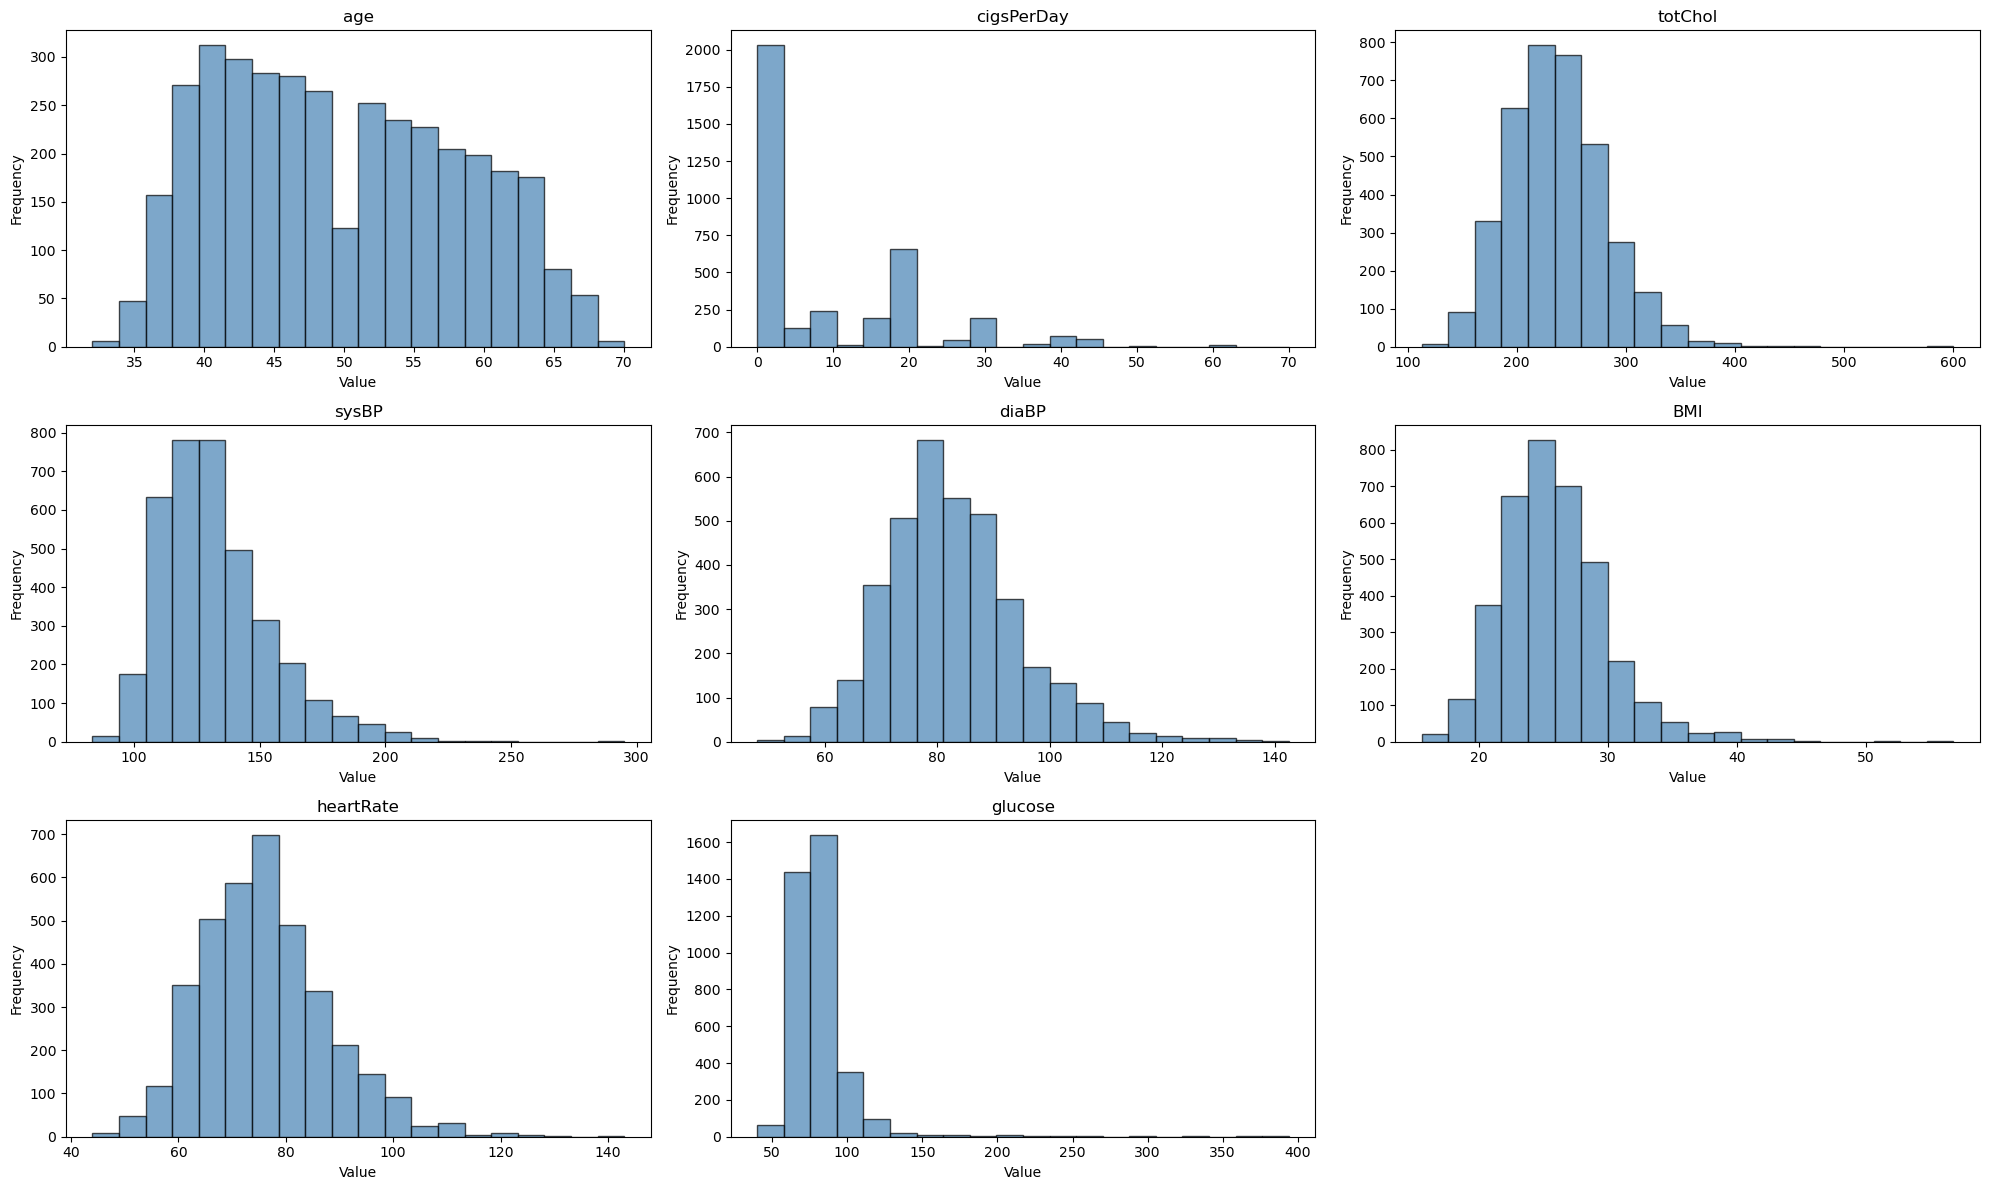

In [135]:
# Histograms grid for each numeric variable (with frequencies on y-axis)
# List of numerical columns
num_columns = [col for col in df.columns if col in ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

# Chart grid settings
n_cols = 3  
n_rows = int(np.ceil(len(num_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Generating histograms
for i, col in enumerate(num_columns):
    axes[i].hist(df[col], bins=20, color="steelblue", edgecolor="black", alpha=0.7)
    
    # Labels
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("Value", fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)

# Hide empty axes (if variables are less than n_rows * n_cols)
for j in range(len(num_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

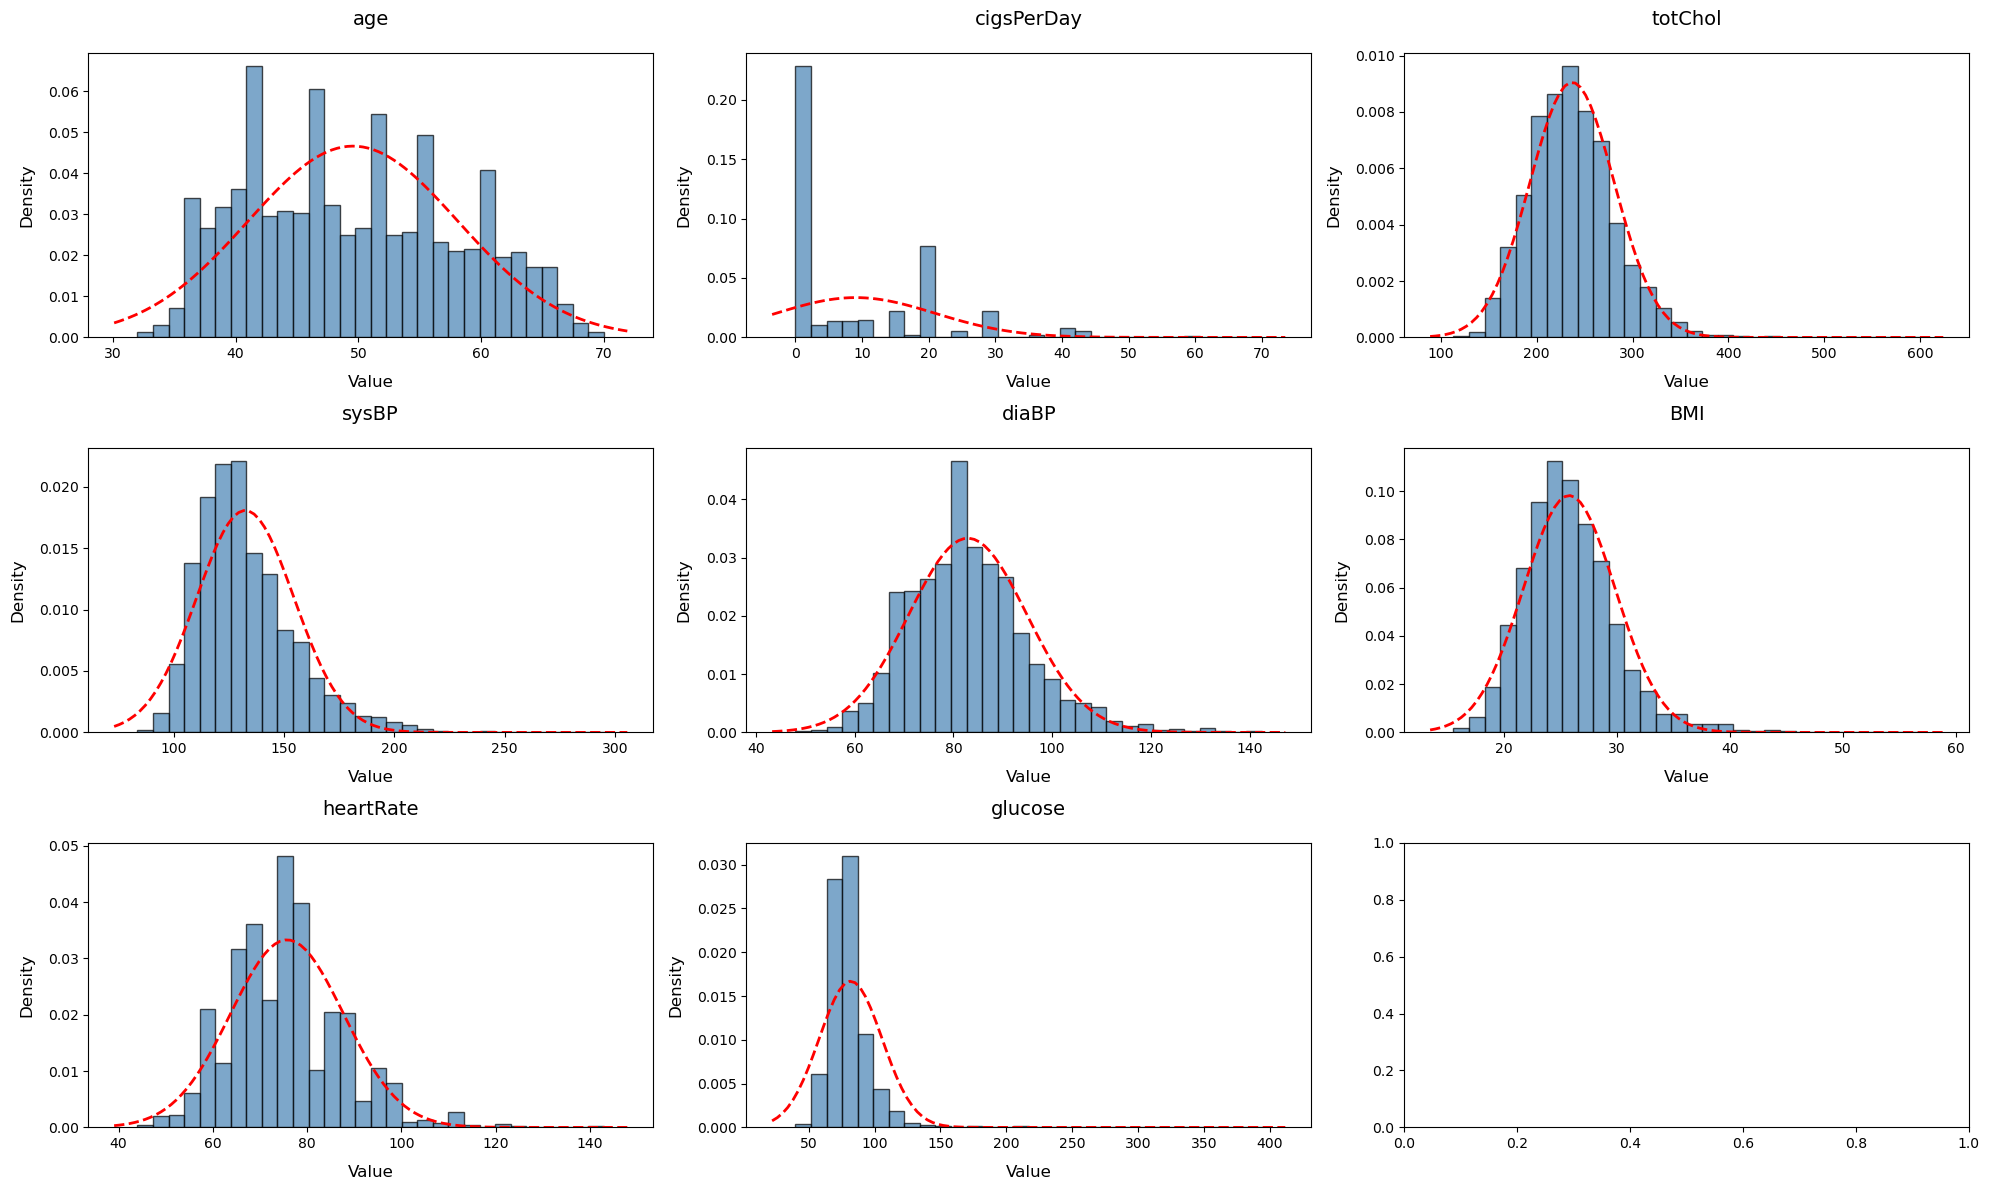

In [136]:
# Histograms grid for each numeric variable with normal distribution line to examine distribution shape (with density on y-axis)
# List of numerical columns
num_columns = [col for col in df.columns if col in ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

# Chart grid settings
n_cols = 3  
n_rows = int(np.ceil(len(num_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Generating histograms and adding normal distribution lines
for i, col in enumerate(num_columns):
    # Histogram
    n, bins, patches = axes[i].hist(df[col], bins=30, color="steelblue", edgecolor="black", alpha=0.7, density=True)
    
    # Normal distribution parameters
    mu, std = norm.fit(df[col])
    
    # Normal distribution lines
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'r--', linewidth=2)
    
    # Labels
    axes[i].set_title(f"{col}", fontsize=14, pad=20)
    axes[i].set_xlabel("Value", fontsize=12, labelpad=10)
    axes[i].set_ylabel("Density", fontsize=12, labelpad=10)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [137]:
# Calculate skewness and kurtosis for numeric columns
for col in num_columns:
    skewness = skew(df[col])
    kurt = kurtosis(df[col])  
    print(f'Skewness and kurtosis value for {col}:')
    print(f'\nSkewness: {skewness:.2f}')
    print(f'Kurtosis: {kurt:.2f}')
    print('='*50)


Skewness and kurtosis value for age:

Skewness: 0.23
Kurtosis: -0.99
Skewness and kurtosis value for cigsPerDay:

Skewness: 1.23
Kurtosis: 0.95
Skewness and kurtosis value for totChol:

Skewness: 0.66
Kurtosis: 1.84
Skewness and kurtosis value for sysBP:

Skewness: 1.16
Kurtosis: 2.27
Skewness and kurtosis value for diaBP:

Skewness: 0.71
Kurtosis: 1.26
Skewness and kurtosis value for BMI:

Skewness: 1.00
Kurtosis: 2.83
Skewness and kurtosis value for heartRate:

Skewness: 0.67
Kurtosis: 1.06
Skewness and kurtosis value for glucose:

Skewness: 6.28
Kurtosis: 60.05


Based on histograms and skeweness/kurtosis values we can conclude that:

- Age: Age data is fairly symmetrical but has fewer outliers, indicating a flatter distribution.

- CigsPerDay: The number of cigarettes smoked per day is skewed to the right, with more people smoking fewer cigarettes, but there are some heavy smokers. The distribution has a sharper peak than normal.

- TotChol (Total Cholesterol): Total cholesterol levels are skewed to the right, indicating more people have lower cholesterol levels, but there are some with very high levels. The distribution is sharply peaked with more outliers.

- SysBP (Systolic Blood Pressure): Systolic blood pressure is right-skewed, showing that more individuals have lower blood pressure levels, but there are some with very high levels. The distribution has a sharper peak and more outliers than normal.

- DiaBP (Diastolic Blood Pressure): Diastolic blood pressure is right-skewed, indicating more people have lower levels, but there are some with higher levels. The distribution has a sharper peak and more outliers than normal.

- BMI (Body Mass Index): BMI is right-skewed, showing more individuals with lower BMI, but some with very high BMI. The distribution is sharply peaked with more outliers.

- HeartRate: Heart rate is slightly skewed to the right, with more individuals having lower heart rates, but the distribution is close to normal.

- Glucose: Glucose levels are highly right-skewed, indicating most people have lower glucose levels, but there are some with extremely high levels. The distribution has an extremely sharp peak with many outliers, suggesting significant deviations from normality.

These results indicate that most of the numeric variables are positively skewed, meaning they have longer tails on the right side of the distribution. It also means that most values are lower than the mean of this variable. The mean is 'pulled' upward by a few large values on the right side of the distribution.  Additionally variables like glucose show extreme skewness and kurtosis, suggesting the presence of significant outliers and deviations from normality. Adjustments or transformations may be needed for better modeling performance.

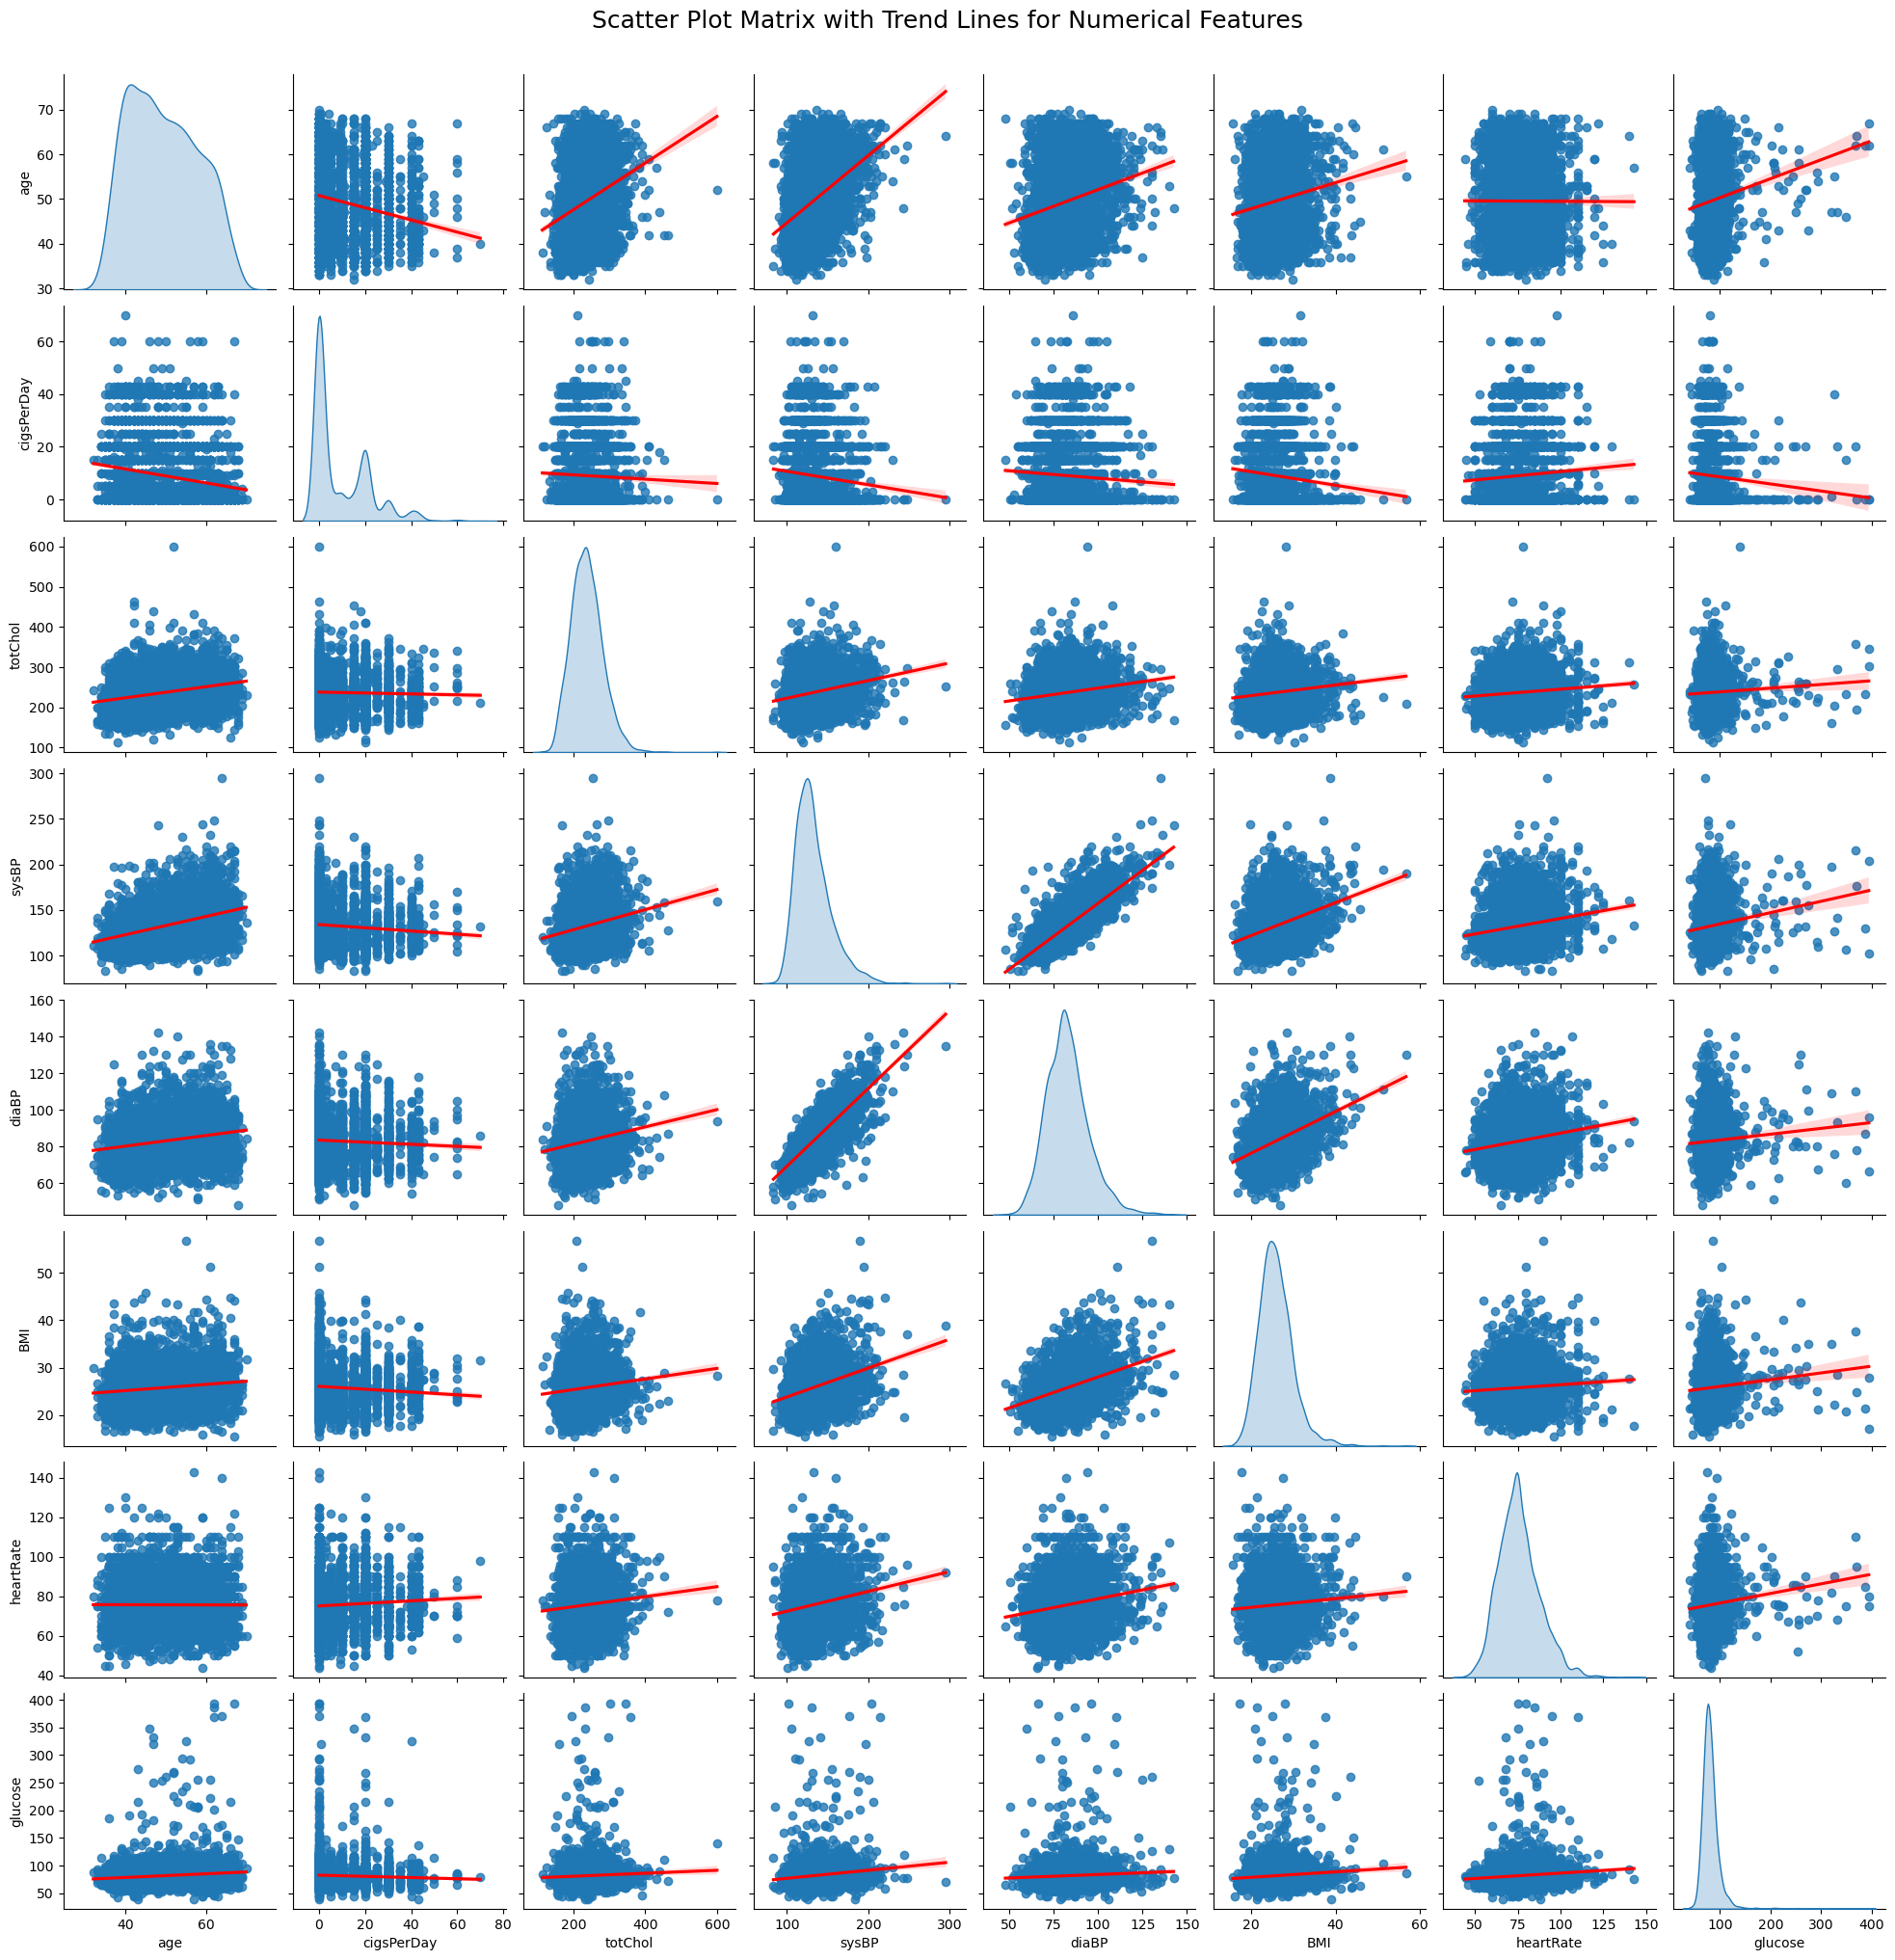

In [138]:
# Scatter plot matrix with trend lines
sns.pairplot(df[num_columns], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}})

# Adding a title to the entire scatter plot matrix
plt.suptitle('Scatter Plot Matrix with Trend Lines for Numerical Features', fontsize=18, y=1.02)

plt.show()


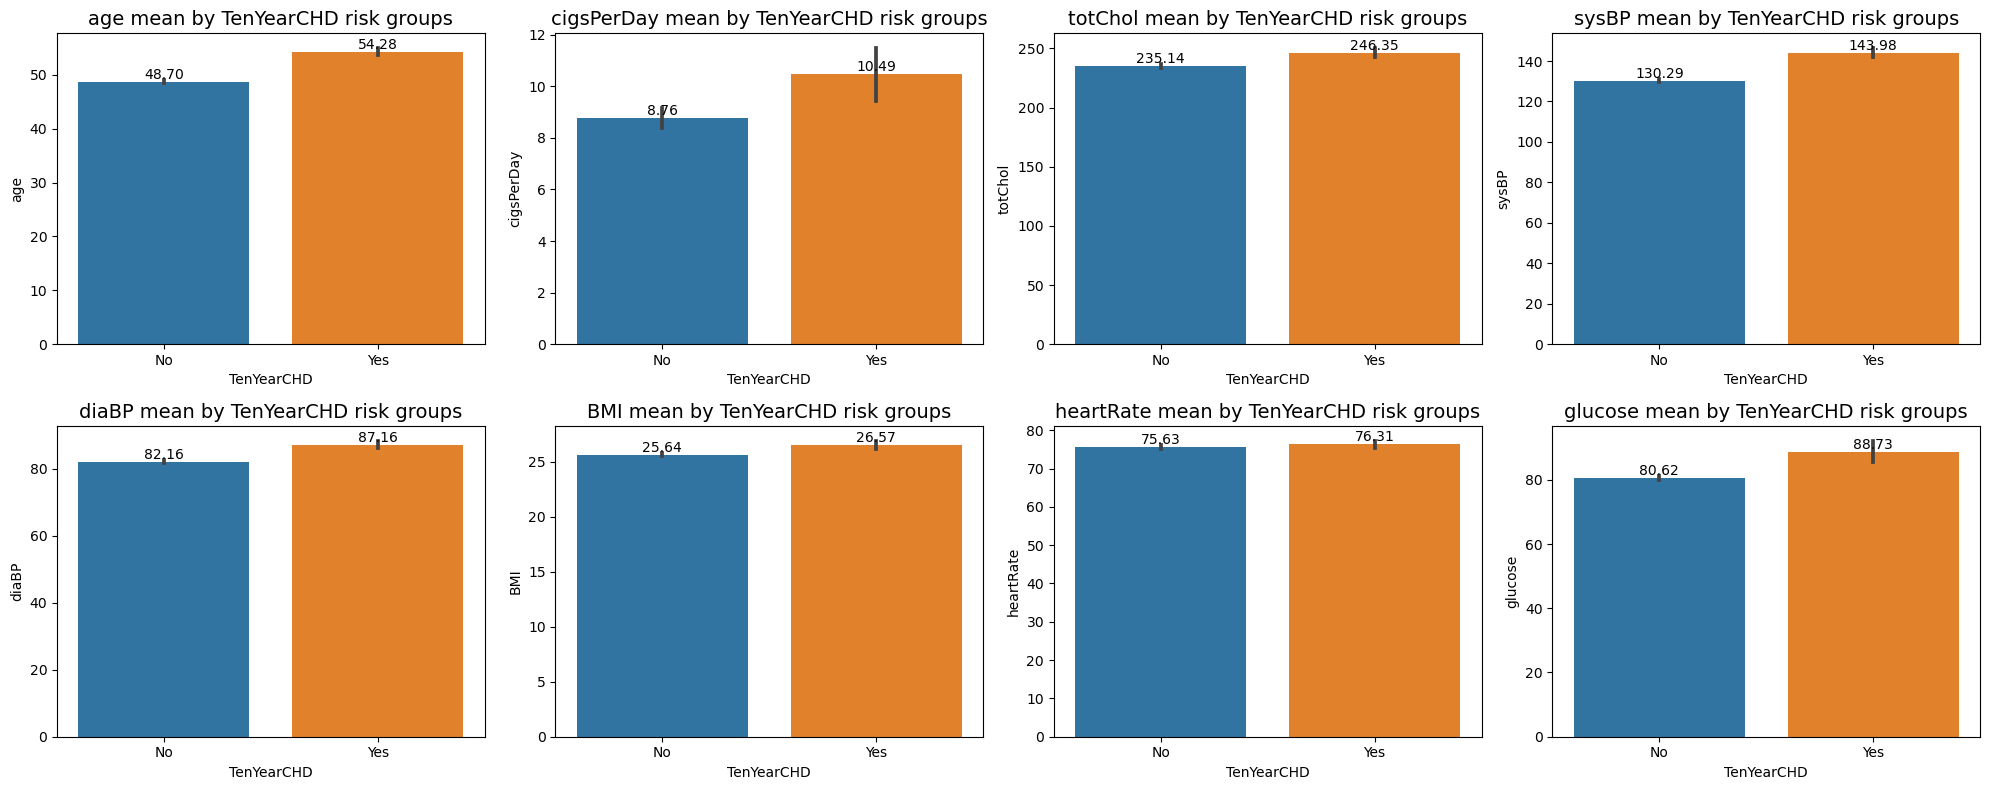

In [139]:
# Replace 'TenYearCHD' category labels with 'Yes' and 'No' for plotting purposes
df['TenYearCHD_plot'] = df['TenYearCHD'].map({0: 'No', 1: 'Yes'})

# Mean bar chart grid for each variable to examine differences between 10-year risk of coronary heart disease groups
n_cols = 4 
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()  

for i, col in enumerate(num_columns):
    sns.barplot(
        x='TenYearCHD_plot', 
        y=col, 
        data=df, 
        ax=axes[i], 
        ci=95  
    )
    # Add mean values on the bars with two decimal places
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2, p.get_height()), 
                         ha='center', va='bottom', fontsize=10)
    
    axes[i].set_title(f'{col} mean by TenYearCHD risk groups', fontsize=14)
    axes[i].set_xlabel('TenYearCHD')
    axes[i].set_ylabel(col)

# Hide empty axes (if variables are less than n_rows * n_cols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


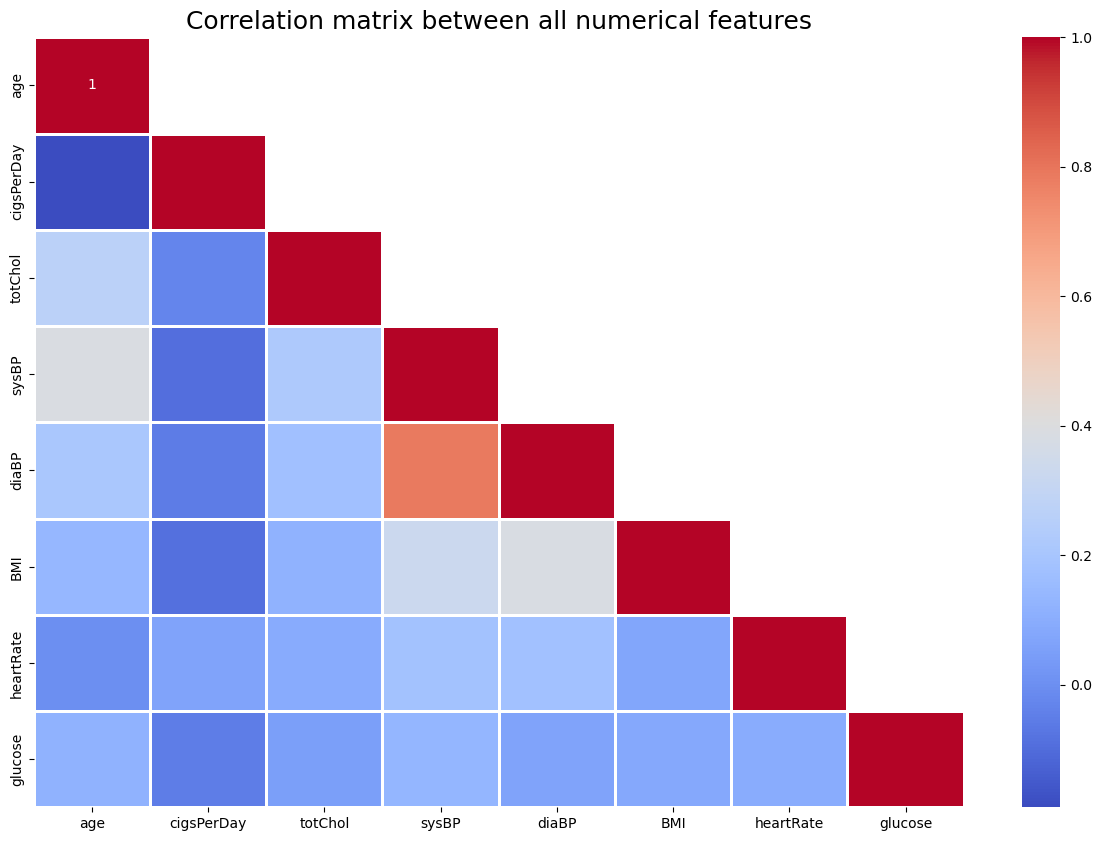

In [140]:
# correlation matrix for numerical features
num_corr_matrix = df[num_columns].corr()

# lower and upper triangle masks 
num_upper_mask = np.triu(num_corr_matrix, k=1)
num_lower_mask = np.tril(num_corr_matrix, k=1)


# linear correlation between features
plt.figure(figsize=(15,10))
sns.heatmap(df[num_columns].corr(), mask=num_upper_mask, cmap='coolwarm', linewidths=2, annot=True)
plt.title('Correlation matrix between all numerical features', fontsize=18)
plt.show()

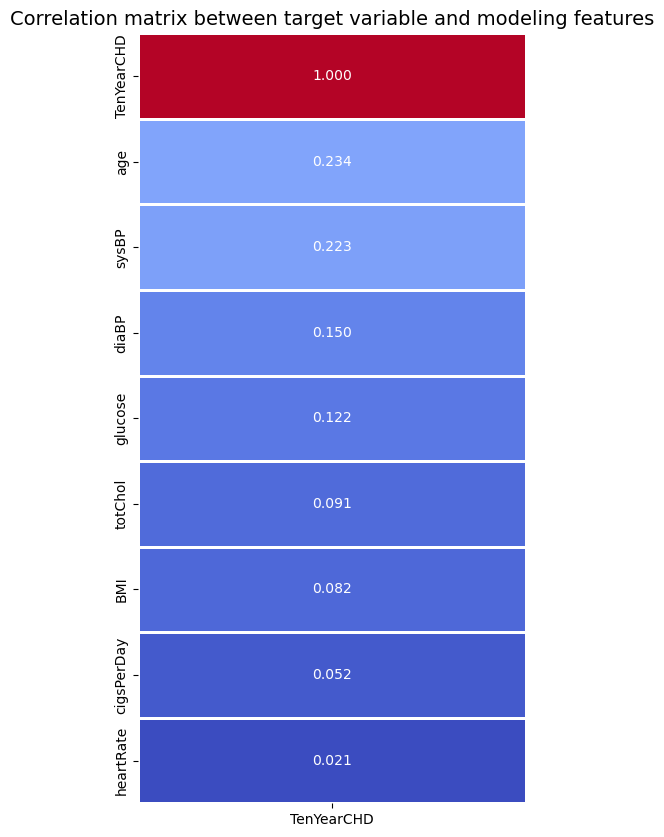

In [141]:
num_correlation_df = pd.concat([df[num_columns], df['TenYearCHD']], axis=1)

correlation_matrix = num_correlation_df.corr()

TenYearCHD_correlation = correlation_matrix['TenYearCHD'].sort_values(ascending=False)

plt.figure(figsize=(5, 10))
sns.heatmap(TenYearCHD_correlation.to_frame(), annot=True, cmap='coolwarm', linewidths=2, cbar=False, fmt='.3f')
plt.title('Correlation matrix between target variable and modeling features', fontsize=14)
plt.show()

Age:

- Positively correlated with total cholesterol (0.27), systolic BP (0.39), and diastolic BP (0.21).

- Indicates that as age increases, these variables also tend to increase.

CigsPerDay:

- Negatively correlated with age (-0.19), indicating younger individuals tend to smoke more.

- Correlation values are generally low, suggesting weak relationships with other variables.

TotChol (Total Cholesterol):

- Positively correlated with age (0.27), systolic BP (0.22), and diastolic BP (0.17).

- Indicates higher cholesterol levels are associated with higher blood pressure and older age.

SysBP (Systolic Blood Pressure):

- Strongly positively correlated with diastolic BP (0.78).

- Moderate positive correlations with age (0.39) and BMI (0.33).

- Indicates that higher systolic BP is associated with higher diastolic BP, older age, and higher BMI.

DiaBP (Diastolic Blood Pressure):

- Strongly positively correlated with systolic BP (0.79).

- Moderate positive correlations with BMI (0.33) and age (0.21).

- Indicates that higher diastolic BP is associated with higher systolic BP, higher BMI, and older age.

BMI (Body Mass Index):

- Positively correlated with systolic BP (0.33) and diastolic BP (0.39).

- Indicates that higher BMI is associated with higher blood pressure levels.

HeartRate:

- Generally low correlation values with other variables, indicating weak relationships.

Glucose:

- Generally low correlation values with other variables, indicating weak relationships.

Overall, there are some moderate to strong correlations, especially between systolic and diastolic blood pressure. Age shows a positive relationship with blood pressure and cholesterol levels, suggesting these factors increase with age. Other variables, like heart rate and glucose, have generally weak correlations with the other features.

In [142]:
# Mapping 'TenYearCHD' labels to 'Yes' and 'No'
df['TenYearCHD_plot'] = df['TenYearCHD'].map({0: 'No', 1: 'Yes'})

# Initialize list for results
ttest_results = []

# Performing t-Student test
for col in num_columns:
    # Splitting data into two groups
    group1 = df[df['TenYearCHD'] == 0][col]
    group2 = df[df['TenYearCHD'] == 1][col]
    
    # Conducting t-Student test
    t_stat, p_val = ttest_ind(group1, group2)
    
    # Storing results along with means
    ttest_results.append({
        'Variable': col, 
        'Mean (No CHD)': round(group1.mean(), 2), 
        'Mean (Yes CHD)': round(group2.mean(), 2),
        't-statistic': t_stat, 
        'p-value': f'{p_val:.2f}'
    })

# Converting results to DataFrame
ttest_df = pd.DataFrame(ttest_results)

# Displaying results
print(ttest_df)



     Variable  Mean (No CHD)  Mean (Yes CHD)  t-statistic p-value
0         age          48.70           54.28   -14.551682    0.00
1  cigsPerDay           8.76           10.49    -3.149270    0.00
2     totChol         235.14          246.35    -5.545925    0.00
3       sysBP         130.29          143.98   -13.820300    0.00
4       diaBP          82.16           87.16    -9.181306    0.00
5         BMI          25.64           26.57    -4.978245    0.00
6   heartRate          75.63           76.31    -1.240639    0.21
7     glucose          80.62           88.73    -7.431607    0.00


- Age: Age is significantly higher in individuals with CHD compared to those without. The difference is statistically significant.

- CigsPerDay: The number of cigarettes smoked per day is significantly higher in individuals with CHD. This difference is statistically significant.

- TotChol (Total Cholesterol): Total cholesterol levels are significantly higher in individuals with CHD. The difference is statistically significant.

- SysBP (Systolic Blood Pressure): Systolic blood pressure is significantly higher in individuals with CHD. The difference is statistically significant.

- DiaBP (Diastolic Blood Pressure): Diastolic blood pressure is significantly higher in individuals with CHD. The difference is statistically significant.

- BMI (Body Mass Index): BMI is significantly higher in individuals with CHD. The difference is statistically significant.

- HeartRate: There is no statistically significant difference in heart rate between individuals with and without CHD.

- Glucose: Glucose levels are significantly higher in individuals with CHD. The difference is statistically significant.

These results indicate that variables such as age, cigarettes per day, total cholesterol, systolic blood pressure, diastolic blood pressure, BMI, and glucose are significantly higher in individuals with CHD. The heart rate, however, does not show a statistically significant difference.

The largest absolute t-statistic values for the variables age and sysBP indicate that these variables show relatively the greatest differences between the means in the groups at risk and not at risk of developing coronary heart disease. This means that these variables have the greatest impact on the difference between these two groups and are strongly associated with the occurrence of the disease.

Information Value of each column

In [143]:
# function to calculate Information Value and Weight of Evidence
# WoE = ln(Non_event_percentage/Event_percentage)
# IV = sigma(Event_percentage - Non_event_percentage) * WoE
# Event is probe when we have patient with one of our targeted diseases
# Non-event is probe when we have patient with one of our targeted diseases

def iv_calc(data, target, bins=10, woe_show=True):
    
    # Data frames to fill
    iv_df, woe_df = pd.DataFrame(), pd.DataFrame()
    
    # Independent variables list
    col_list = data.columns
    
    # WOE and IV calculation for each independent variable
    for col in col_list[~col_list.isin([target])]:
        if (data[col].dtype.kind in 'bifc') and (len(np.unique(data[col])) > 10):
            binned_x = pd.qcut(data[col], bins, duplicates='drop') # binned_x is to balance number of observation in each bin, so WoE wouldn't be biased
            d_temp = pd.DataFrame({'x': binned_x,
                                   'y': data[target]})
        else:
            d_temp = pd.DataFrame({'x': data[col],
                                   'y': data[target]})
            
        # Number of events in each group (bin)
        d = d_temp.groupby('x', as_index=False).agg({
            'y': ['count','sum']})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Percentage of events in each group (bin)
        d['Event_percentage'] = d['Events']/d['Events'].sum()
        
        # Non-events in each group (bin)
        d['Non_events'] = np.abs(d['N'] - d['Events'])
        # Non-events percentage in each group
        d['Non_event_percentage'] = d['Non_events']/d['Non_events'].sum()
        
        # WoE calculation 
        d['WoE'] = np.log(d['Event_percentage']/d['Non_event_percentage'])
        d['IV'] = d['WoE'] * (d['Event_percentage'] - d['Non_event_percentage'])
        d.insert(loc=0, column='Variable', value=col)
        tmp = pd.DataFrame({'Variable': [col],
                            'IV': [d['IV'].sum()]},
                            columns = ['Variable','IV'])
        iv_df = pd.concat([iv_df, tmp], axis=0)
        woe_df = pd.concat([woe_df, d], axis=0)
        
        # Whether to show WoE data frame
        if woe_show == True:
            print(woe_df)
    
    return iv_df, woe_df

In [144]:
# calculation of Information Value for variables in our dataset
iv_df = iv_calc(data=df.iloc[:,:-1], target='TenYearCHD', bins=10, woe_show=False)[0]
iv_df.sort_values(by='IV', ascending=False)

,Variable,IV
0,age,0.472370
0,sysBP,0.336415
0,prevalentHyp,0.234698
0,diaBP,0.195528
0,totChol,0.078902
0,education,0.065704
0,sex,0.064688
0,BMI,0.064498
0,diabetes,0.048841
0,glucose,0.048096


Based on results of statistical significance, correlation and information value of independent variables it was decided to keep almost all of them except:
- heartRate
- currentSmoker

Feature scalling

In [145]:
cat_columns

['sex',
 'education',
 'currentSmoker',
 'BPMeds',
 'prevalentStroke',
 'prevalentHyp',
 'diabetes',
 'TenYearCHD']

In [146]:
# dropping insignificant variables - heartRate and currentSmoker
scaled_data = df.loc[:,~df.columns.isin(['heartRate','currentSmoker','TenYearCHD_plot'])].copy()
num_columns.remove('heartRate')

In [147]:
# standard scaler initiation
scaler = StandardScaler()

# feature scaling of numerical variables
scaled_data[num_columns] = scaler.fit_transform(scaled_data[num_columns])

# glance at the results
scaled_data.head()

,sex,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,glucose,TenYearCHD
0,1,-1.232580,4,-0.757169,0.0,0,0,0,-0.949108,-1.194111,-1.078881,0.292050,-0.203044,0
1,0,-0.414905,2,-0.757169,0.0,0,0,0,0.298294,-0.514881,-0.160118,0.725010,-0.244883,0
2,1,-0.181283,1,0.920689,0.0,0,0,0,0.184894,-0.220548,-0.243642,-0.108929,-0.495920,0
3,0,1.337256,3,1.759618,0.0,0,1,0,-0.268707,0.798296,1.009217,0.688110,0.884782,1
4,0,-0.414905,3,1.172368,0.0,0,0,0,1.092095,-0.107344,0.090454,-0.659969,0.131672,0


In [148]:
scaled_data['TenYearCHD'].value_counts()

TenYearCHD
0    3101
1     557
Name: count, dtype: int64

Train, test split + resampling

In [149]:
# Splitting the data into features (X) and target variable (y)
X = scaled_data.drop('TenYearCHD', axis=1)
y = scaled_data['TenYearCHD']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# resampling of X_train and y_train with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Logistic Regression optimized model

[I 2025-02-03 14:59:19,087] A new study created in memory with name: no-name-dd0ff08e-a33a-4bf0-9a0e-4c2736814efd
[I 2025-02-03 14:59:19,188] Trial 0 finished with value: 0.7289797377243148 and parameters: {'C': 0.17949976993841565, 'penalty': 'l2'}. Best is trial 0 with value: 0.7289797377243148.


[I 2025-02-03 14:59:19,278] Trial 1 finished with value: 0.7310564977322026 and parameters: {'C': 0.1298222838163795, 'penalty': 'l1'}. Best is trial 1 with value: 0.7310564977322026.
[I 2025-02-03 14:59:19,314] Trial 2 finished with value: 0.7362699664760403 and parameters: {'C': 0.04101830038323226, 'penalty': 'l1'}. Best is trial 2 with value: 0.7362699664760403.
[I 2025-02-03 14:59:19,360] Trial 3 finished with value: 0.727771889173733 and parameters: {'C': 3.495330547899391, 'penalty': 'l2'}. Best is trial 2 with value: 0.7362699664760403.
[I 2025-02-03 14:59:19,406] Trial 4 finished with value: 0.7358447544862946 and parameters: {'C': 0.010111408132688671, 'penalty': 'l2'}. Best is trial 2 with value: 0.7362699664760403.
[I 2025-02-03 14:59:19,463] Trial 5 finished with value: 0.7276917767698678 and parameters: {'C': 7.553443265050448, 'penalty': 'l2'}. Best is trial 2 with value: 0.7362699664760403.
[I 2025-02-03 14:59:19,521] Trial 6 finished with value: 0.727679451784658 and p

Best hyperparameters: {'C': 0.0011478668418558014, 'penalty': 'l2'}
Best AUC score: 0.7399859495168605

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       922
           1       0.29      0.66      0.41       176

    accuracy                           0.69      1098
   macro avg       0.61      0.68      0.60      1098
weighted avg       0.82      0.69      0.73      1098

AUC Score: 0.740


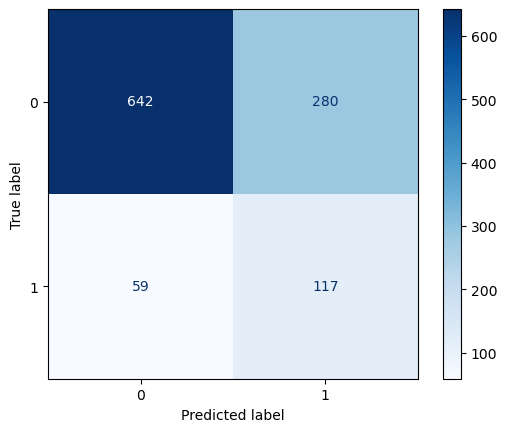

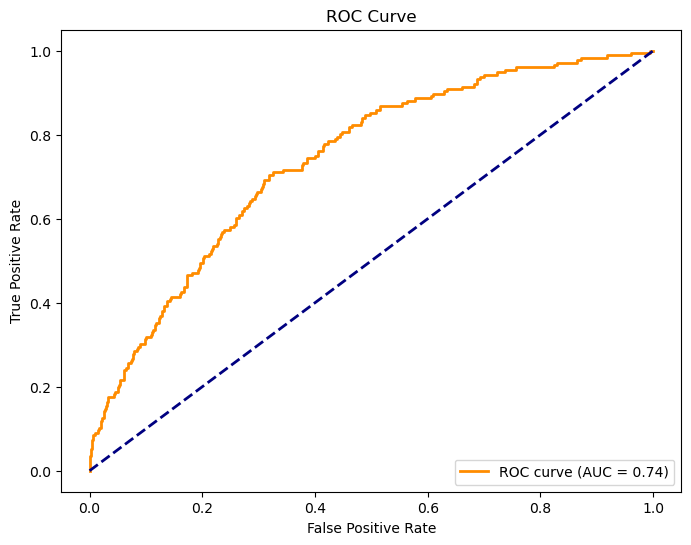


Feature Importance:
            Feature  Importance
1               age    0.320929
9             sysBP    0.169640
3        cigsPerDay    0.127382
10            diaBP    0.087842
12          glucose    0.071583
8           totChol    0.067448
0               sex    0.045653
11              BMI    0.038453
4            BPMeds    0.023175
6      prevalentHyp    0.016767
5   prevalentStroke    0.000496
7          diabetes   -0.002094
2         education   -0.119621

Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
362        0          0     0.315846
1632       0          0     0.459755
283        0          0     0.211426
1325       0          0     0.222372
2154       0          0     0.247270
2426       0          1     0.500252
1025       0          0     0.374024
3923       0          1     0.598868
1141       0          1     0.592808
198        0          1     0.603139


In [150]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    C = trial.suggest_float('C', 0.001, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Create and train the logistic regression model
    lr_model = LogisticRegression(random_state=42, penalty=penalty, C=C, solver='liblinear')
    lr_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict probabilities for the test set
    y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]
    
    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_prob_lr)
    
    return auc_score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and AUC score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")

# Train the final model with the best hyperparameters
best_lr_model = LogisticRegression(random_state=42, **study.best_params, solver='liblinear')
best_lr_model.fit(X_train_resampled, y_train_resampled)

# Predictions and probability predictions
y_pred_lr = best_lr_model.predict(X_test)
y_pred_prob_lr = best_lr_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap='Blues')

# Calculation of AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_lr)
print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance (model coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_lr_model.coef_[0]
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_lr,
    'Probability': y_pred_prob_lr
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))

In [151]:
# calibration Logistic Regression model
lr_calibrated = CalibratedClassifierCV(best_lr_model, method='isotonic', cv='prefit')  # Sigmoid scaling
lr_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=0.0011478668418558014,
                                                    random_state=42,
                                                    solver='liblinear'),
                       method='isotonic')

KNN optimized model

[I 2025-02-03 14:59:23,396] A new study created in memory with name: no-name-c41e05a4-d19a-4c2b-92b6-c8aac2718509
[I 2025-02-03 14:59:23,787] Trial 0 finished with value: 0.6590847465983041 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.6590847465983041.
[I 2025-02-03 14:59:24,058] Trial 1 finished with value: 0.6450065322421613 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.6590847465983041.
[I 2025-02-03 14:59:24,480] Trial 2 finished with value: 0.6578645730625123 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.6590847465983041.
[I 2025-02-03 14:59:24,939] Trial 3 finished with value: 0.6632228603825675 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.6632228603825675.
[I 2025-02-03 14:59:25,226] Trial 4 finished with value: 0.6369151794517847 and parameters: {'n_neighbors': 5, 'weights'

Best hyperparameters: {'n_neighbors': 50, 'weights': 'distance', 'p': 1}
Best AUC score: 0.697865312561625

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       922
           1       0.27      0.68      0.38       176

    accuracy                           0.65      1098
   macro avg       0.59      0.66      0.57      1098
weighted avg       0.81      0.65      0.70      1098

AUC Score: 0.698


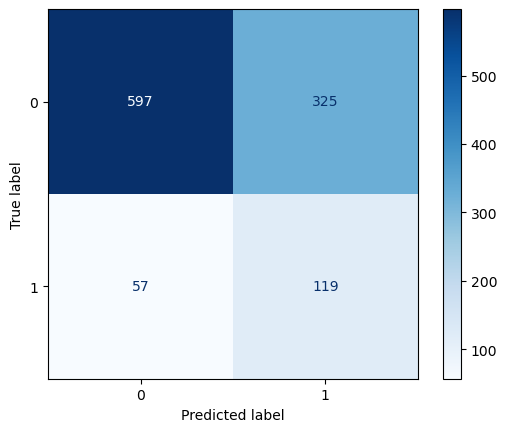

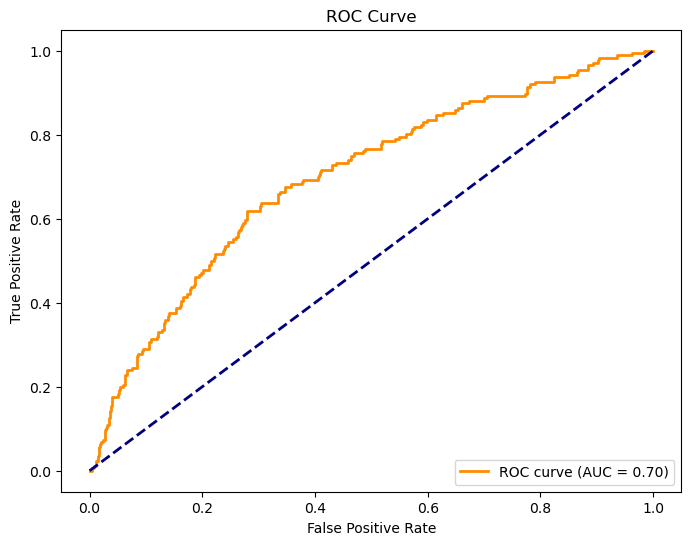


Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
362        0          0     0.095580
1632       0          0     0.376493
283        0          0     0.057550
1325       0          0     0.144836
2154       0          0     0.136025
2426       0          0     0.431024
1025       0          0     0.286426
3923       0          1     0.549210
1141       0          1     0.675178
198        0          1     0.577215


In [152]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 3, 50)  # Number of neighbors
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Weight function
    p = trial.suggest_int('p', 1, 2)  # Power parameter for Minkowski distance (1: Manhattan, 2: Euclidean)

    # Create and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    knn_model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for the test set
    y_pred_prob_knn = knn_model.predict_proba(X_test)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_prob_knn)

    return auc_score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and AUC score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")

# Train the final model with the best hyperparameters
best_knn_model = KNeighborsClassifier(**study.best_params)
best_knn_model.fit(X_train_resampled, y_train_resampled)

# Predictions and probability predictions
y_pred_knn = best_knn_model.predict(X_test)
y_pred_prob_knn = best_knn_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues')

# Calculation of AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_knn)
print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_knn,
    'Probability': y_pred_prob_knn
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))

In [153]:
# calibration Logistic Regression model
knn_calibrated = CalibratedClassifierCV(best_knn_model, method='sigmoid', cv='prefit')  # Sigmoid scaling
knn_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=KNeighborsClassifier(n_neighbors=50, p=1,
                                                      weights='distance'))

Random Forest optimized model

[I 2025-02-03 14:59:48,330] A new study created in memory with name: no-name-401fb06b-8413-4a8a-8d9b-7bfe80c94def
[I 2025-02-03 14:59:52,544] Trial 0 finished with value: 0.6752612896864524 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6752612896864524.
[I 2025-02-03 14:59:56,254] Trial 1 finished with value: 0.6834820548215342 and parameters: {'n_estimators': 223, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.6834820548215342.
[I 2025-02-03 15:00:03,829] Trial 2 finished with value: 0.6834142674028791 and parameters: {'n_estimators': 473, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.6834820548215342.
[I 2025-02-03 15:00:09,177] Trial 3 finished with value: 0.6841784164859003 and parameters: {'n_estimators': 343, 'max_depth': 8, 'min

Best hyperparameters: {'n_estimators': 72, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'log2'}
Best AUC score: 0.7058765529481364

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.78       922
           1       0.27      0.60      0.37       176

    accuracy                           0.67      1098
   macro avg       0.58      0.64      0.57      1098
weighted avg       0.80      0.67      0.71      1098

AUC Score: 0.706


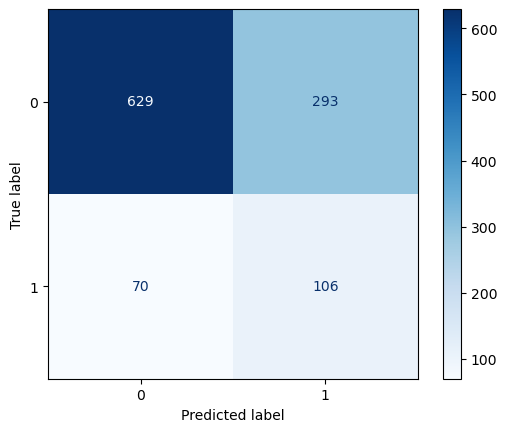

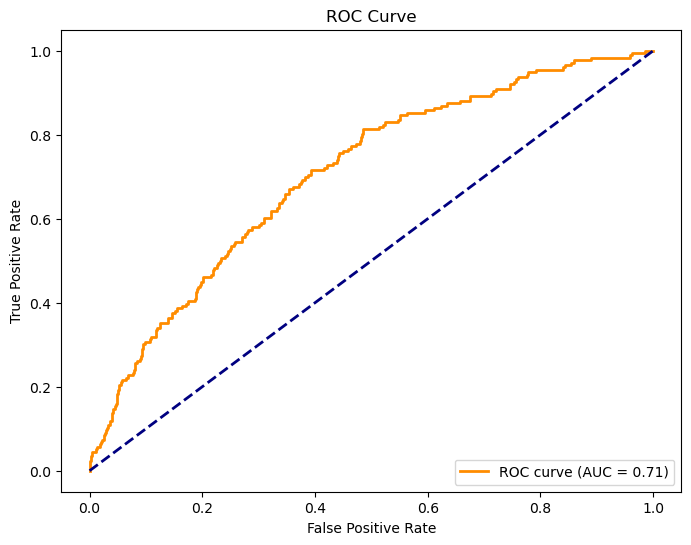


Feature Importance:
            Feature  Importance
1               age    0.394748
9             sysBP    0.166507
2         education    0.090944
10            diaBP    0.077620
3        cigsPerDay    0.069756
4            BPMeds    0.051732
12          glucose    0.043234
8           totChol    0.040626
6      prevalentHyp    0.033213
11              BMI    0.026261
0               sex    0.004599
7          diabetes    0.000762
5   prevalentStroke    0.000000

Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
362        0          0     0.284565
1632       0          0     0.368896
283        0          0     0.212350
1325       0          0     0.199588
2154       0          0     0.207662
2426       0          1     0.531447
1025       0          0     0.302934
3923       0          1     0.648847
1141       0          1     0.642814
198        0          1     0.568823


In [154]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)  # Number of trees
    max_depth = trial.suggest_int('max_depth', 2, 10)  # Maximum depth of each tree
    min_samples_split = trial.suggest_int('min_samples_split', 3, 10)  # Minimum samples to split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10)  # Minimum samples at leaf node
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])  # Features to consider for splits

    # Create and train the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for the test set
    y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_prob_rf)

    return auc_score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and AUC score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")

# Train the final model with the best hyperparameters
best_rf_model = RandomForestClassifier(
    **study.best_params,
    random_state=42
)
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions and probability predictions
y_pred_rf = best_rf_model.predict(X_test)
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')

# Calculation of AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_rf)
print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rf,
    'Probability': y_pred_prob_rf
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))


In [155]:
# calibration of Random Forest model
rf_calibrated = CalibratedClassifierCV(best_rf_model, method='isotonic', cv='prefit')
rf_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=10,
                                                        min_samples_split=7,
                                                        n_estimators=72,
                                                        random_state=42),
                       method='isotonic')

XGBoost optimized model

[I 2025-02-03 15:01:34,858] A new study created in memory with name: no-name-7aefa86a-bbbc-4c45-8663-2aa135049ce0
[I 2025-02-03 15:01:37,385] Trial 0 finished with value: 0.6632752415697101 and parameters: {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.06000518371725845, 'subsample': 0.8629324774118949, 'colsample_bytree': 0.7953403790222084, 'reg_alpha': 0.12019935412463334, 'reg_lambda': 0.8103295901669209}. Best is trial 0 with value: 0.6632752415697101.
[I 2025-02-03 15:01:40,891] Trial 1 finished with value: 0.6724820055215934 and parameters: {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.011830628985976052, 'subsample': 0.6409497586732339, 'colsample_bytree': 0.8283556993499095, 'reg_alpha': 0.9344320754446505, 'reg_lambda': 0.8985327095716169}. Best is trial 1 with value: 0.6724820055215934.
[I 2025-02-03 15:01:42,608] Trial 2 finished with value: 0.6593990337211595 and parameters: {'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.039590981542809746, '

Best hyperparameters: {'n_estimators': 51, 'max_depth': 3, 'learning_rate': 0.010698957097339947, 'subsample': 0.9908488950015054, 'colsample_bytree': 0.6004008126044835, 'reg_alpha': 0.006961682823101278, 'reg_lambda': 0.3756354959319904}
Best AUC score: 0.6982134933938079

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75       922
           1       0.26      0.64      0.37       176

    accuracy                           0.64      1098
   macro avg       0.58      0.64      0.56      1098
weighted avg       0.80      0.64      0.69      1098

AUC Score: 0.698


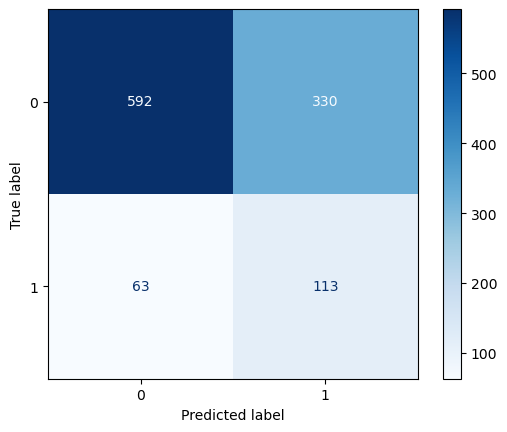

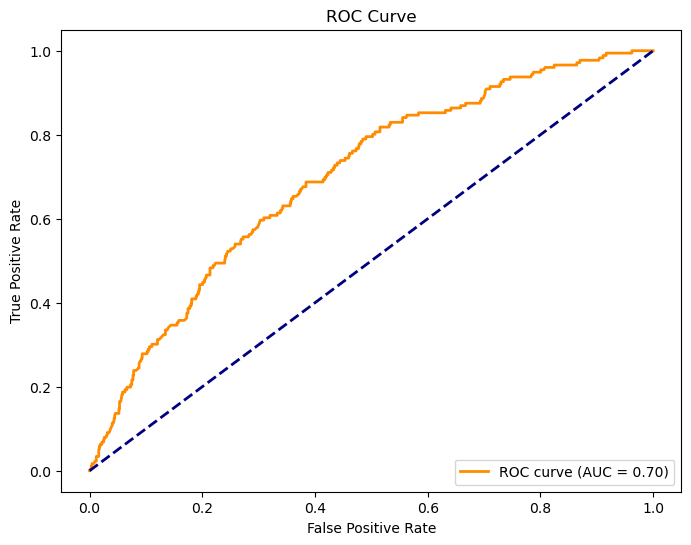


Feature Importance:
            Feature  Importance
1               age    0.244393
9             sysBP    0.180754
2         education    0.160030
6      prevalentHyp    0.069159
3        cigsPerDay    0.068081
4            BPMeds    0.066296
10            diaBP    0.063019
8           totChol    0.056254
12          glucose    0.043371
11              BMI    0.039095
7          diabetes    0.009547
0               sex    0.000000
5   prevalentStroke    0.000000

Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
362        0          0     0.416132
1632       0          0     0.443402
283        0          0     0.390513
1325       0          0     0.357831
2154       0          0     0.381963
2426       0          1     0.519437
1025       0          0     0.423626
3923       0          1     0.559653
1141       0          1     0.555202
198        0          1     0.549090


In [156]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # Number of boosting rounds
        'max_depth': trial.suggest_int('max_depth', 3, 5),  # Maximum depth of each tree
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Step size shrinkage
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Fraction of samples used for training
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Fraction of features used for training
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),  # L2 regularization
        'random_state': 42,
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'auc',  # Metric to optimize
        'use_label_encoder': False,
    }

    # Create and train the XGBoost model
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(
        X_train_resampled,
        y_train_resampled,
        eval_set=[(X_test, y_test)],
        verbose=False,
    )

    # Predict probabilities for the test set
    y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_prob_xgb)

    return auc_score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and AUC score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")

# Train the final model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(
    **study.best_params,
    random_state=42,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
)
best_xgb_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test, y_test)],
    verbose=False,
)

# Predictions and probability predictions
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Blues')

# Calculation of AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb,
    'Probability': y_pred_prob_xgb
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))

CatBoost optimized model

[I 2025-02-03 15:02:29,920] A new study created in memory with name: no-name-3dea55df-77e7-4dbb-98ac-94992550af47
[I 2025-02-03 15:02:33,470] Trial 0 finished with value: 0.6698567836718596 and parameters: {'iterations': 124, 'depth': 9, 'learning_rate': 0.13744548546761054, 'l2_leaf_reg': 3.5524398736326033, 'border_count': 122, 'subsample': 0.8916199888428982}. Best is trial 0 with value: 0.6698567836718596.
[I 2025-02-03 15:02:37,891] Trial 1 finished with value: 0.6457059751528298 and parameters: {'iterations': 285, 'depth': 9, 'learning_rate': 0.09521268006754421, 'l2_leaf_reg': 5.227613138218, 'border_count': 94, 'subsample': 0.7922492535997995}. Best is trial 0 with value: 0.6698567836718596.
[I 2025-02-03 15:02:41,892] Trial 2 finished with value: 0.6890344606586472 and parameters: {'iterations': 442, 'depth': 4, 'learning_rate': 0.01669213432499838, 'l2_leaf_reg': 9.52533497889871, 'border_count': 193, 'subsample': 0.9400941081629123}. Best is trial 2 with value: 0.68903446065

Best hyperparameters: {'iterations': 163, 'depth': 3, 'learning_rate': 0.024587333261568565, 'l2_leaf_reg': 7.825294493507301, 'border_count': 131, 'subsample': 0.9101510385361424}
Best AUC score: 0.7064373397751923

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.78       922
           1       0.28      0.66      0.39       176

    accuracy                           0.67      1098
   macro avg       0.60      0.67      0.58      1098
weighted avg       0.81      0.67      0.71      1098

AUC Score: 0.706


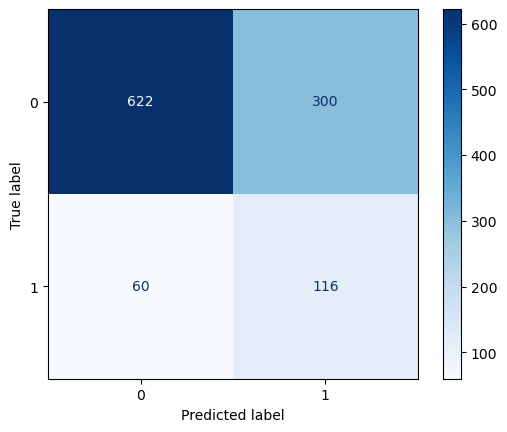

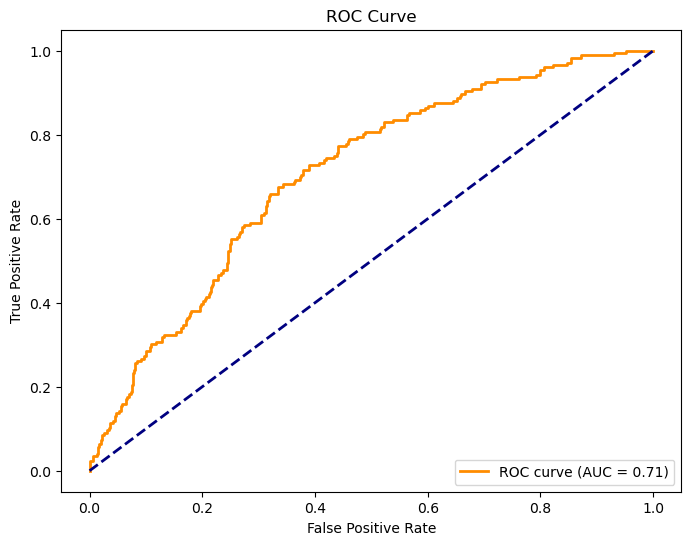


Feature Importance:
            Feature  Importance
1               age   47.769181
3        cigsPerDay   19.472066
9             sysBP   10.164215
2         education    7.056874
4            BPMeds    6.905581
10            diaBP    2.977249
12          glucose    2.682237
8           totChol    1.977250
11              BMI    0.450618
0               sex    0.306472
6      prevalentHyp    0.233133
7          diabetes    0.005123
5   prevalentStroke    0.000000

Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
362        0          0     0.252446
1632       0          0     0.347419
283        0          0     0.145534
1325       0          0     0.144494
2154       0          0     0.223462
2426       0          1     0.555345
1025       0          0     0.258214
3923       0          1     0.653610
1141       0          1     0.628446
198        0          1     0.666723


In [157]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),  # Number of boosting rounds
        'depth': trial.suggest_int('depth', 3, 10),  # Maximum depth of each tree
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Step size shrinkage
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),  # L2 regularization
        'border_count': trial.suggest_int('border_count', 32, 255),  # Number of splits for numerical features
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Fraction of samples used for training
        'random_state': 42,
        'verbose': False,  # Suppress training logs
    }

    # Create and train the CatBoost model
    catboost_model = CatBoostClassifier(**params)
    catboost_model.fit(
        X_train_resampled,
        y_train_resampled,
        eval_set=(X_test, y_test),  # Validation set for early stopping
        early_stopping_rounds=10,  # Early stopping to avoid overfitting
        verbose=False,
    )

    # Predict probabilities for the test set
    y_pred_prob_catboost = catboost_model.predict_proba(X_test)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_prob_catboost)

    return auc_score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and AUC score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")

# Train the final model with the best hyperparameters
best_catboost_model = CatBoostClassifier(
    **study.best_params,
    random_state=42,
    verbose=False,
)
best_catboost_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=(X_test, y_test),
    early_stopping_rounds=10,
    verbose=False,
)

# Predictions and probability predictions
y_pred_catboost = best_catboost_model.predict(X_test)
y_pred_prob_catboost = best_catboost_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_catboost))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_catboost, cmap='Blues')

# Calculation of AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_catboost)
print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_catboost)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_catboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_catboost,
    'Probability': y_pred_prob_catboost
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))

In [158]:
# calibration of Random Forest model
catboost_calibrated = CalibratedClassifierCV(best_catboost_model, method='isotonic', cv='prefit')
catboost_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=<catboost.core.CatBoostClassifier object at 0x000001DA5848B1D0>,
                       method='isotonic')

Calibration curve

In [159]:
# Function to plot calibration curve
def plot_calibration_curve(y_true, model, model_name):
    prob_true, prob_pred = calibration_curve(y_true, model.predict_proba(X_test)[:, 1], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label=f'{model_name}')

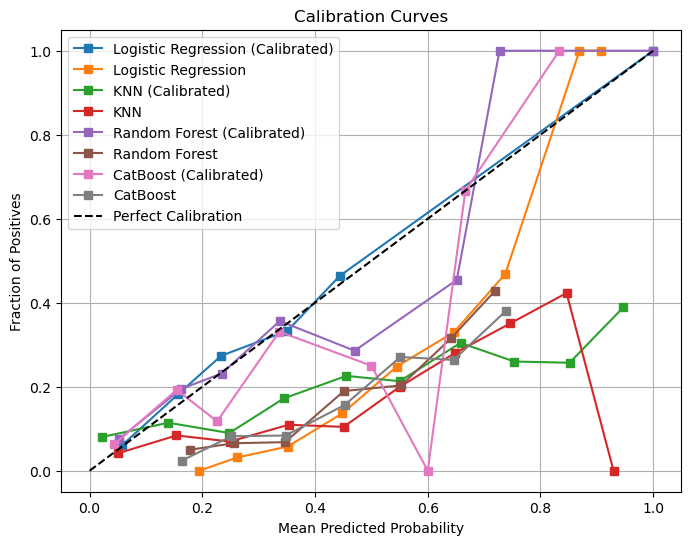

In [160]:
# Plotting calibration curves
plt.figure(figsize=(8, 6))
plot_calibration_curve(y_test, lr_calibrated, "Logistic Regression (Calibrated)")
plot_calibration_curve(y_test, best_lr_model, 'Logistic Regression')
plot_calibration_curve(y_test, knn_calibrated, "KNN (Calibrated)")
plot_calibration_curve(y_test, best_knn_model, "KNN")
plot_calibration_curve(y_test, rf_calibrated, "Random Forest (Calibrated)")
plot_calibration_curve(y_test, best_rf_model, "Random Forest")
plot_calibration_curve(y_test, catboost_calibrated, "CatBoost (Calibrated)")
plot_calibration_curve(y_test, best_catboost_model, "CatBoost")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")    
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend(loc="best")
plt.grid()
plt.show()

Pikcle file preparation

In [161]:
scaled_data

,sex,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,glucose,TenYearCHD
0,1,-1.232580,4,-0.757169,0.0,0,0,0,-0.949108,-1.194111,-1.078881,0.292050,-0.203044,0
1,0,-0.414905,2,-0.757169,0.0,0,0,0,0.298294,-0.514881,-0.160118,0.725010,-0.244883,0
2,1,-0.181283,1,0.920689,0.0,0,0,0,0.184894,-0.220548,-0.243642,-0.108929,-0.495920,0
3,0,1.337256,3,1.759618,0.0,0,1,0,-0.268707,0.798296,1.009217,0.688110,0.884782,1
4,0,-0.414905,3,1.172368,0.0,0,0,0,1.092095,-0.107344,0.090454,-0.659969,0.131672,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,0.052338,1,-0.673276,0.0,0,1,0,1.727136,2.111473,0.758645,0.046051,0.173511,1
4234,1,0.169149,3,2.850225,0.0,0,0,0,-0.676947,-0.265830,-0.243642,-1.493908,-0.579599,0
4237,0,0.285960,2,-0.757169,0.0,0,0,0,0.729214,0.051143,0.006930,-1.060948,1.052139,0
4238,1,-1.115769,3,-0.757169,0.0,0,1,0,-1.175908,0.390758,1.259788,-0.044969,-0.412241,0


In [162]:
# Update numerical and categorical columns based on the actual dataset
numerical_columns = [col for col in ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose'] if col in scaled_data.columns]
categorical_columns = [col for col in ['sex', 'education', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'] if col in scaled_data.columns]

# Print the updated columns to verify
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

# Define preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numerical features
        ('cat', OneHotEncoder(), categorical_columns)  # One-hot encode categorical features
    ]
)

# Define the pipeline with SMOTE and Logistic Regression
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),  # Preprocessing
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # Resampling
    ('classifier', LogisticRegression())  # Classifier
])

# Train the final pipeline with the best hyperparameters
pipeline.set_params(classifier__C=best_lr_model.C, classifier__penalty=best_lr_model.penalty)
pipeline.fit(X_train, y_train)

# Calibration of the pipeline model
calibrated_pipeline = CalibratedClassifierCV(pipeline, method='isotonic', cv='prefit')
calibrated_pipeline.fit(X_train, y_train)

# Save the pipeline to disk
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Save the calibrated pipeline to disk
with open('calibrated_pipeline.pkl', 'wb') as f:
    pickle.dump(calibrated_pipeline, f)


Numerical columns: ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose']
Categorical columns: ['sex', 'education', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']


In [163]:
y_pred = pipeline.predict_proba(X_test)[:,1]
y_pred

array([0.34965516, 0.48409835, 0.24028186, ..., 0.30075498, 0.28645908,
       0.33809076])

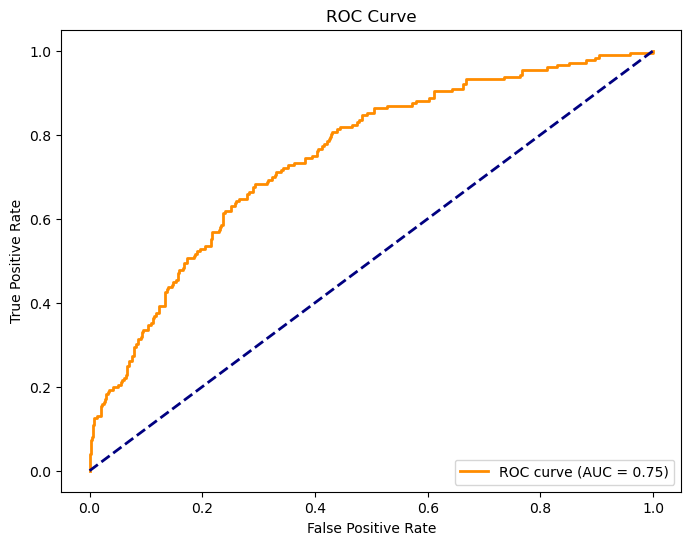

In [164]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()